In [1]:
#%matplotlib notebook
from pyuvdata import UVBeam
import pyuvdata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#from poppy.zernike import zernike
from scipy import stats, special
#from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
from scipy.interpolate import griddata
from scipy.optimize import curve_fit

In [2]:
filename = 'HERA_NF_efield.beamfits'
beam = UVBeam()
beam.read_beamfits(filename, run_check=True)

Npixels=beam.Npixels
nside=beam.nside
print(Npixels,nside)

beam_pstokes=beam.efield_to_pstokes(inplace=False)
beam_pstokes.peak_normalize()
print(beam_pstokes.freq_array)
print(beam_pstokes.polarization_array)
print(pyuvdata.utils.polnum2str(1))
pb=np.sqrt(beam_pstokes.data_array[0,0,0,0,:].real)
pb_fagnoni=beam_pstokes.data_array[0,0,0,0,:].real

12288 32
[[1.00e+08 1.04e+08 1.08e+08 1.12e+08 1.16e+08 1.20e+08 1.24e+08 1.28e+08
  1.32e+08 1.36e+08 1.40e+08 1.44e+08 1.48e+08 1.52e+08 1.56e+08 1.60e+08
  1.64e+08 1.68e+08 1.72e+08 1.76e+08 1.80e+08 1.84e+08 1.88e+08 1.92e+08
  1.96e+08 2.00e+08]]
[1 2 3 4]
pI


In [3]:
beam.data_array.shape, beam_pstokes.data_array.shape

((2, 1, 2, 26, 12288), (1, 1, 4, 26, 12288))

In [4]:
theta, phi = hp.pix2ang(nside, np.arange(Npixels), nest=False, lonlat=False)

theta1=theta[theta < np.pi/2]
phi1=phi[theta < np.pi/2]
pb1=pb[theta < np.pi/2]
pb_fagnoni1=pb_fagnoni[theta < np.pi/2]

#Add za=0 point by hand
theta1 = np.append(0., theta1)
phi1 = np.append(0., phi1)
pb1 = np.append(1., pb1)
pb_fagnoni1 = np.append(1., pb_fagnoni1)

In [5]:
theta2=np.unique(theta1)

pb2=[]
pb_fagnoni2=[]
for th in theta2:
    pb2.append(np.mean(pb1[np.where(theta1==th)]))
    pb_fagnoni2.append(np.mean(pb_fagnoni1[np.where(theta1==th)]))
pb2=np.asarray(pb2)
pb_fagnoni2=np.asarray(pb_fagnoni2)

In [6]:
def gaussian(x, xalpha, A):
    return A*np.exp(-((x)/xalpha)**2)

guess=(0.2,1.0)
fit_params, cov_mat = curve_fit(gaussian, theta2, pb2, p0=guess)

HWHM_rad=fit_params[0]/(2.*0.6)
HWHM=np.rad2deg(fit_params[0]/(2.*0.6))
HWHM

9.606294060645832

In [7]:
import numpy.polynomial

def fit_polynomials(poly_type, order):
    
    # Get appropriate polynomial fitting functions
    if poly_type == 'legendre':
        fit_fn = numpy.polynomial.legendre.legfit
        val_fn = numpy.polynomial.legendre.legval
    elif poly_type == 'chebyshev':
        fit_fn = numpy.polynomial.chebyshev.chebfit
        val_fn = numpy.polynomial.chebyshev.chebval    
    elif poly_type == 'polynomial':
        fit_fn = numpy.polynomial.polynomial.polyfit
        val_fn = numpy.polynomial.polynomial.polyval
    elif poly_type == 'hermite':
        fit_fn = numpy.polynomial.hermite.hermfit
        val_fn = numpy.polynomial.hermite.hermval
    elif poly_type == 'laguerre':
        fit_fn = numpy.polynomial.laguerre.lagfit
        val_fn = numpy.polynomial.laguerre.lagval
    else:
        raise ValueError("Unknown poly_type '%s'" % poly_type)
    
    # Perform fits
    tmptheta2=2.*np.sin(theta2)-1.
    coeff = fit_fn(tmptheta2, pb2, order)
    pb2fit = val_fn(tmptheta2, coeff)
    perdev= (1.-pb2fit/pb2)*100.
    maxperdev=np.max(np.abs(perdev))
    stdperdev=np.std(perdev)
    
    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    
    fig.suptitle("Fitting fn: %s, No. of params %d" % (poly_type, order+1))
    axes[0].plot(np.rad2deg(theta2), pb2, 'r',label=r'PB')
    axes[0].plot(np.rad2deg(theta2), pb2fit, 'b--',label=r'fitted')
    axes[0].set_title('Fit', fontsize=20)
    axes[0].axhline(y=0.,c='k')
    axes[0].set_xlim([0.,np.rad2deg(1.)])
    axes[0].axvline(2*HWHM,color='k',ls='--')
    axes[0].set_xlabel(r'$\theta$ in deg', fontsize=16)
    axes[0].legend()

    axes[1].plot(np.rad2deg(theta2), pb2 - pb2fit,'r')
    axes[1].set_title('Deviation', fontsize=20)
    axes[1].axhline(y=0.,c='k')
    axes[1].set_xlim([0.,np.rad2deg(1.)])
    axes[1].axvline(2*HWHM,color='k',ls='--')
    axes[1].set_xlabel(r'$\theta$ in deg', fontsize=16)
    
    axes[2].plot(np.rad2deg(theta2), perdev,'r')
    axes[2].set_title('% Deviation', fontsize=20)
    axes[2].axhline(y=0.,c='k')
    axes[2].set_xlim([0.,np.rad2deg(1.)])
    axes[2].axvline(2*HWHM,color='k',ls='--')
    axes[2].set_xlabel(r'$\theta$ in deg', fontsize=16)
    
    # Resize plot
    fig.set_size_inches((15., 6.))
    return fig,maxperdev,stdperdev

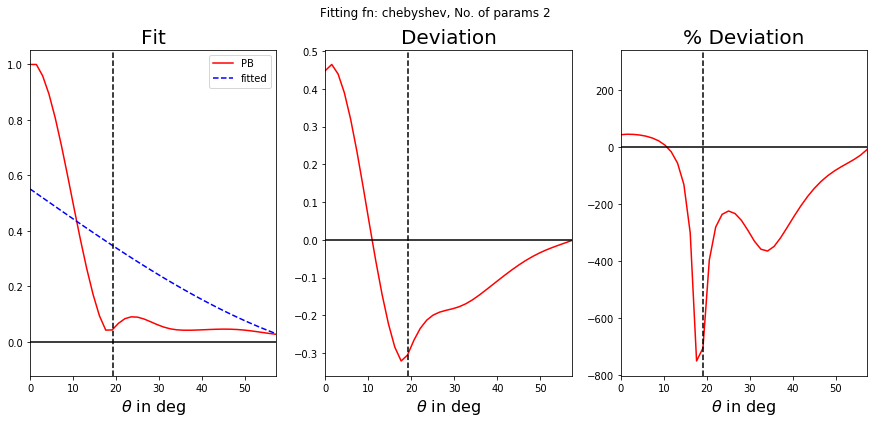

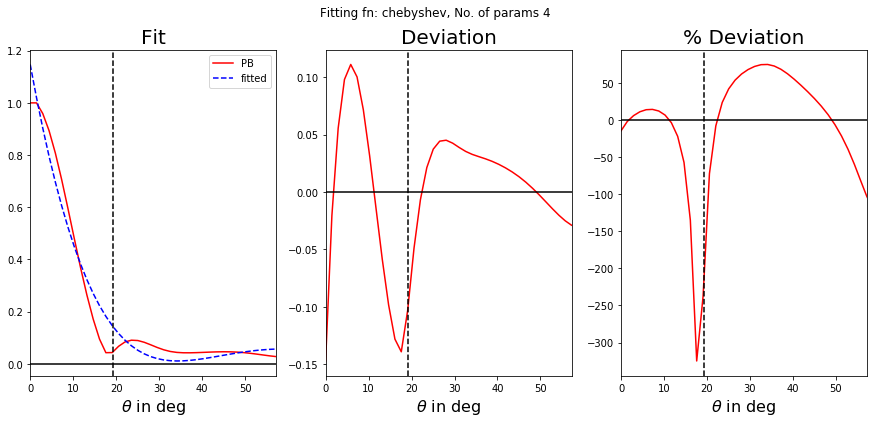

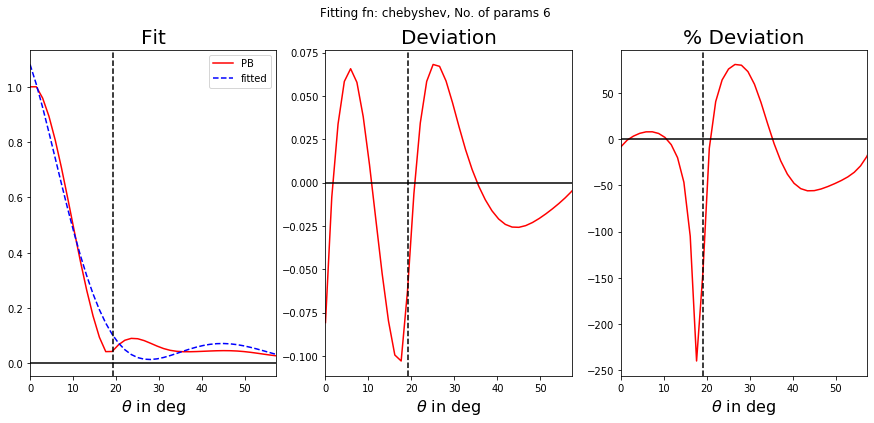

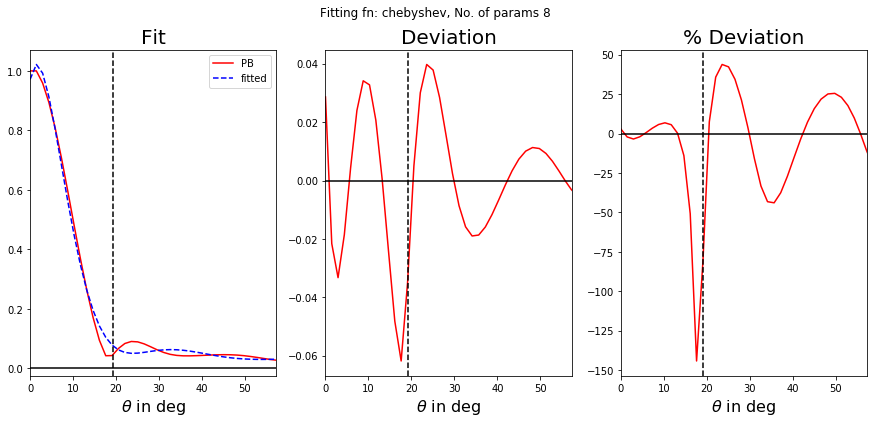

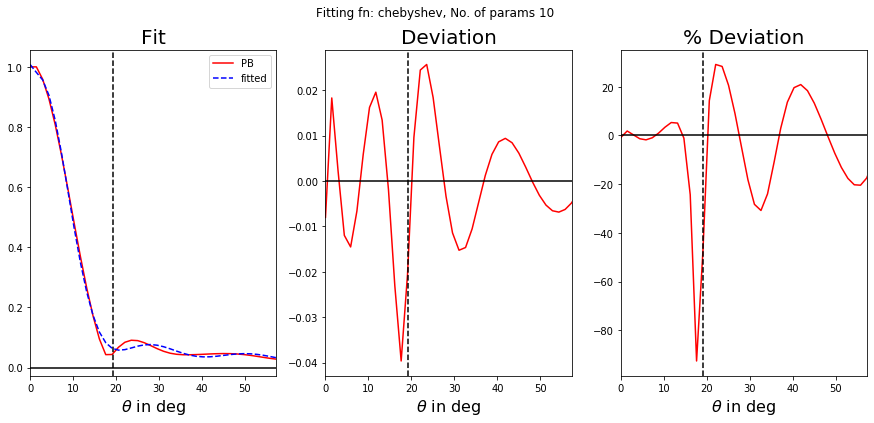

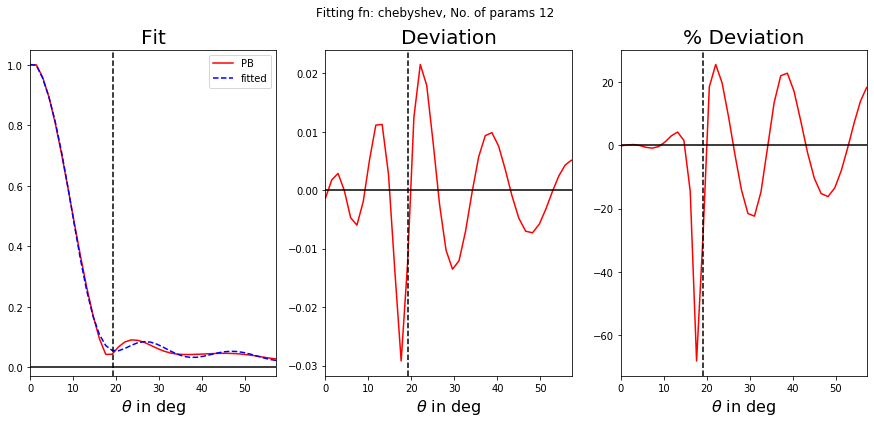

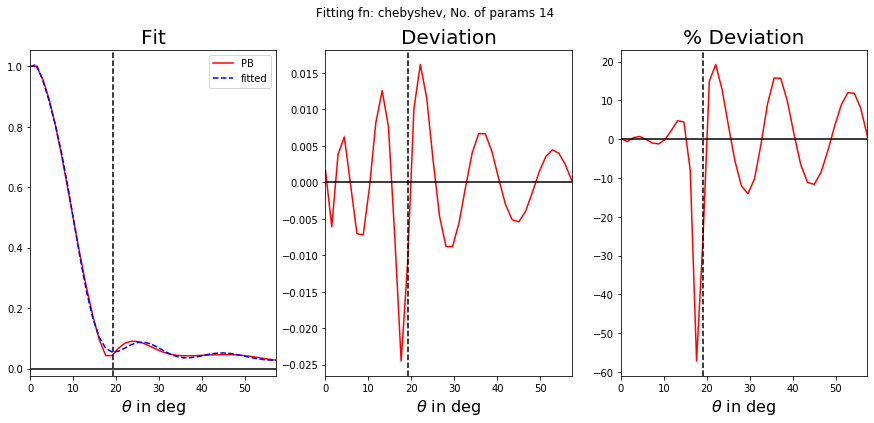

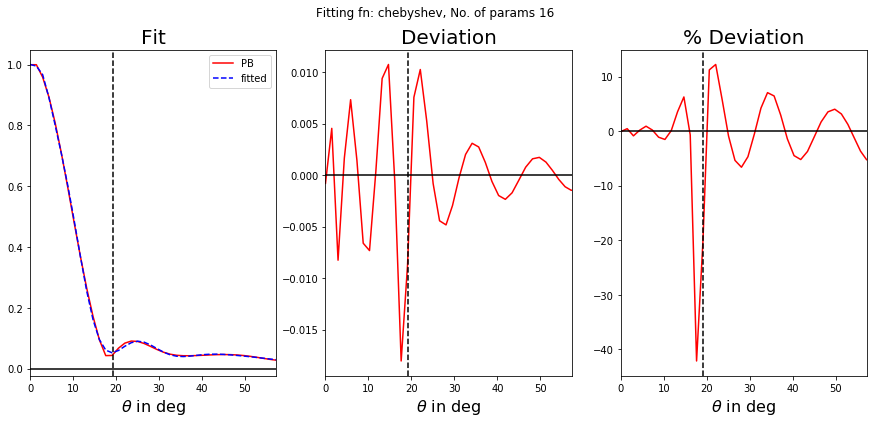

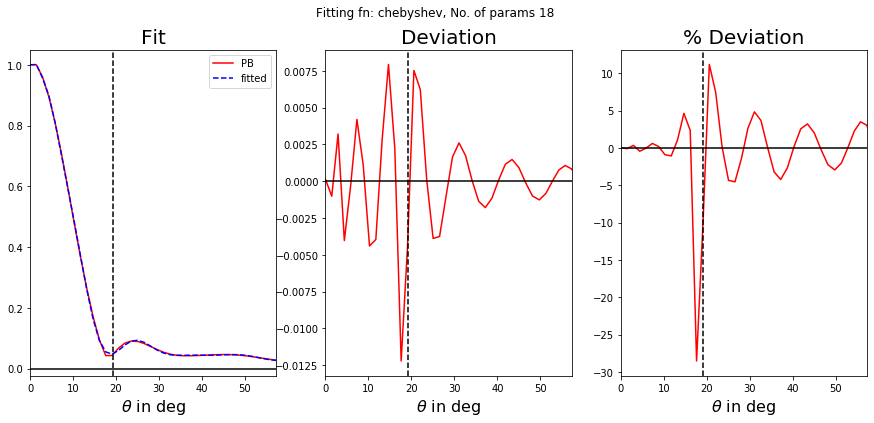

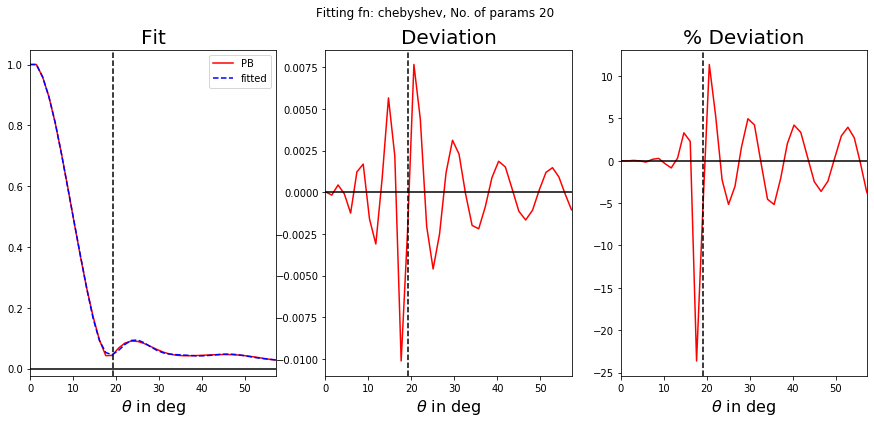

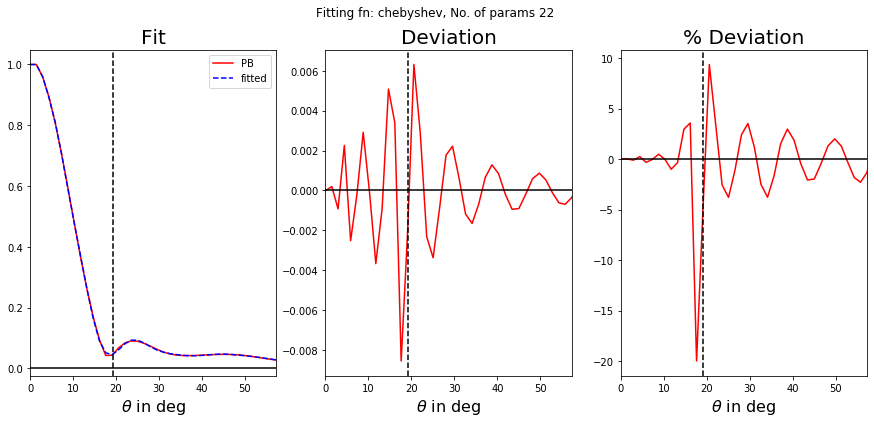

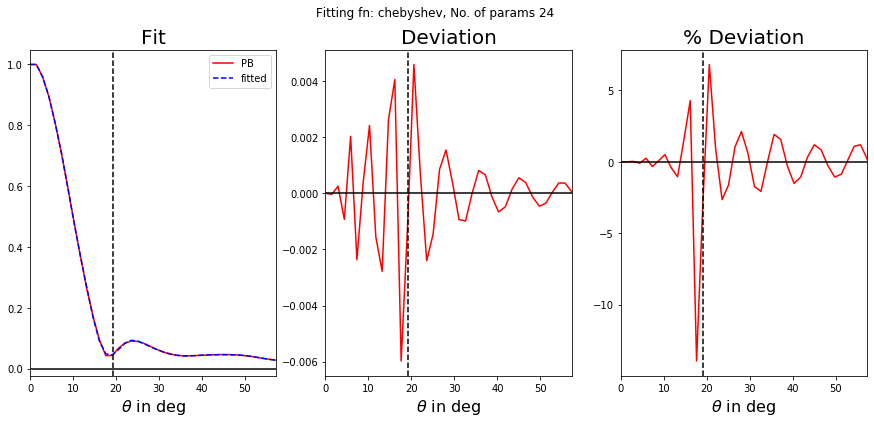

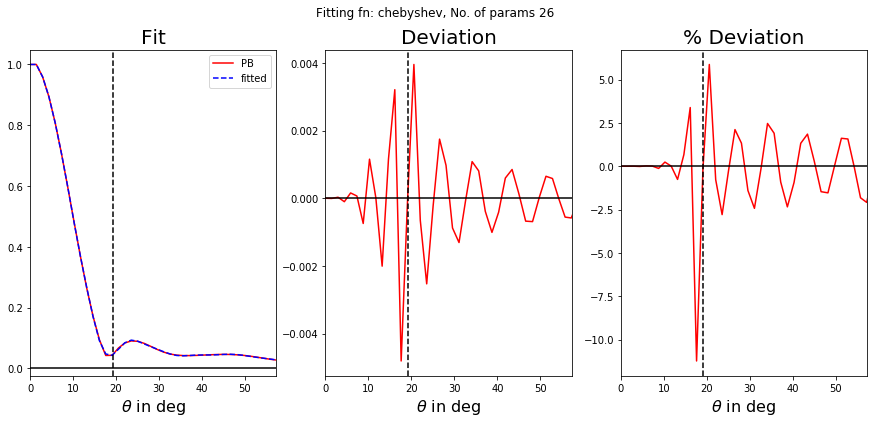

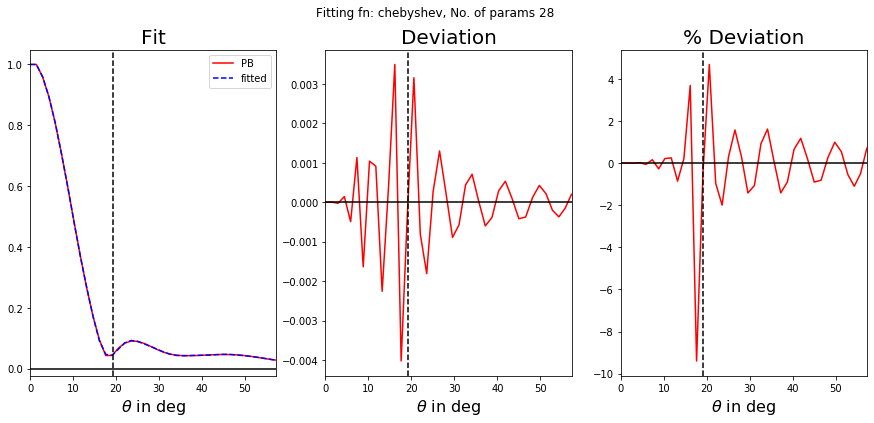

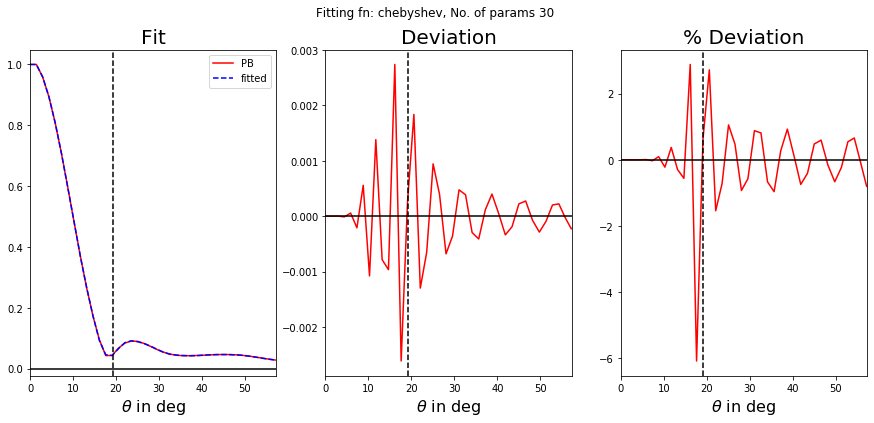

In [8]:
maxcheb = []
stdcheb = []
ordcheb = []
for order in (np.arange(15)*2 + 1):
    fig,max1,std1 = fit_polynomials('chebyshev', order=order)
    maxcheb.append(max1)
    stdcheb.append(std1)
    ordcheb.append(order)
maxcheb=np.asarray(maxcheb)
stdcheb=np.asarray(stdcheb)
ordcheb=np.asarray(ordcheb)

The fit may be poorly conditioned
The fit may be poorly conditioned
The fit may be poorly conditioned
The fit may be poorly conditioned
The fit may be poorly conditioned


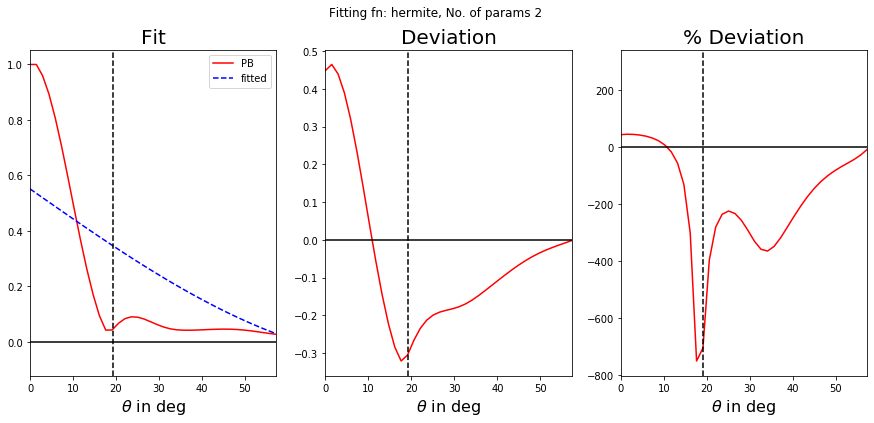

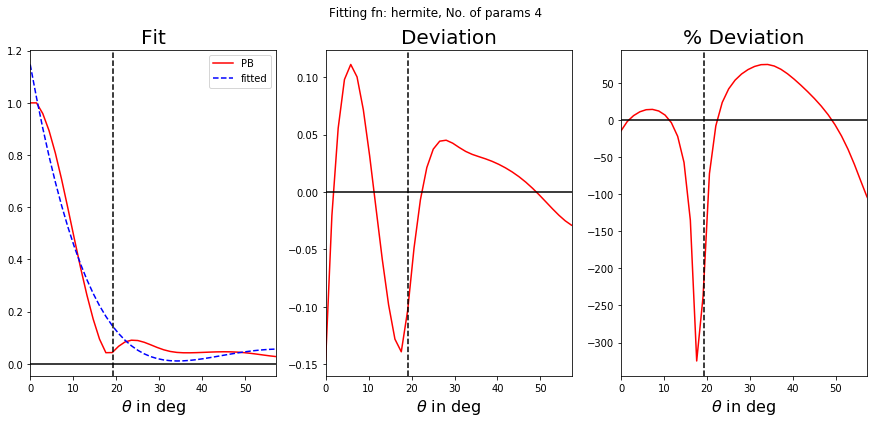

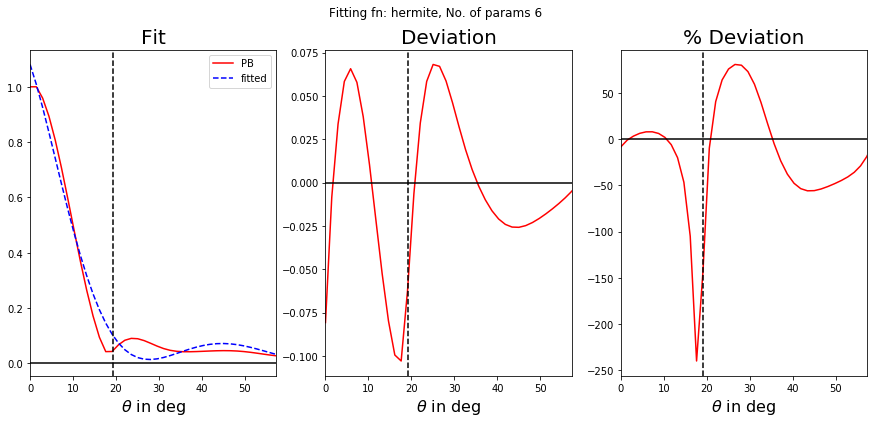

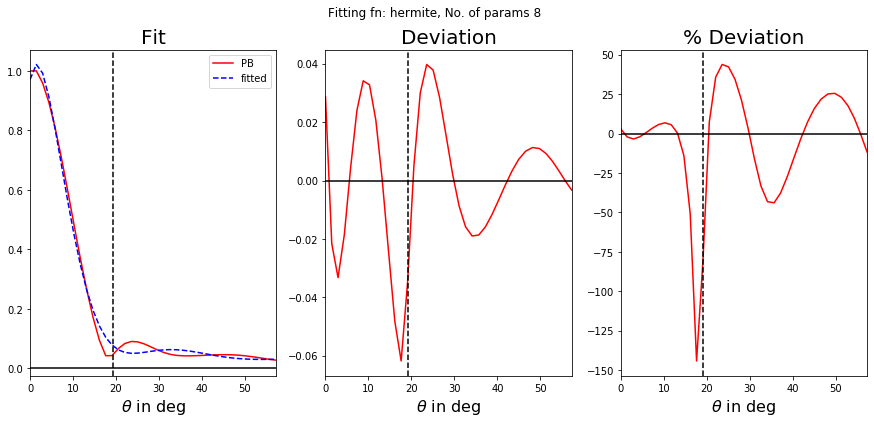

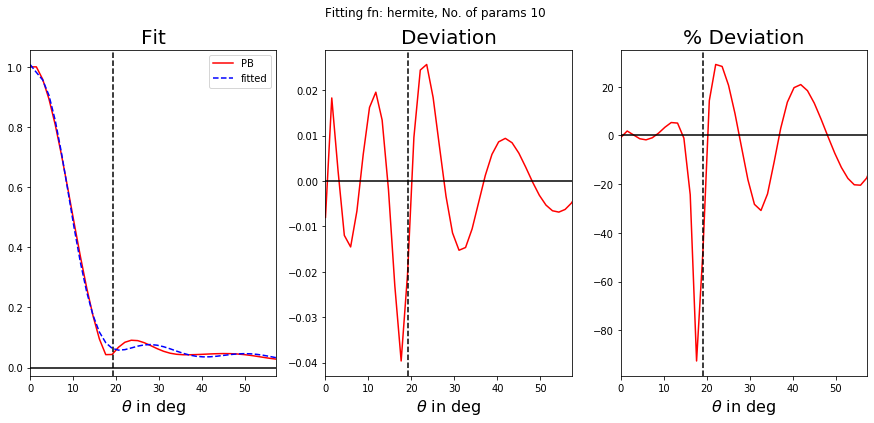

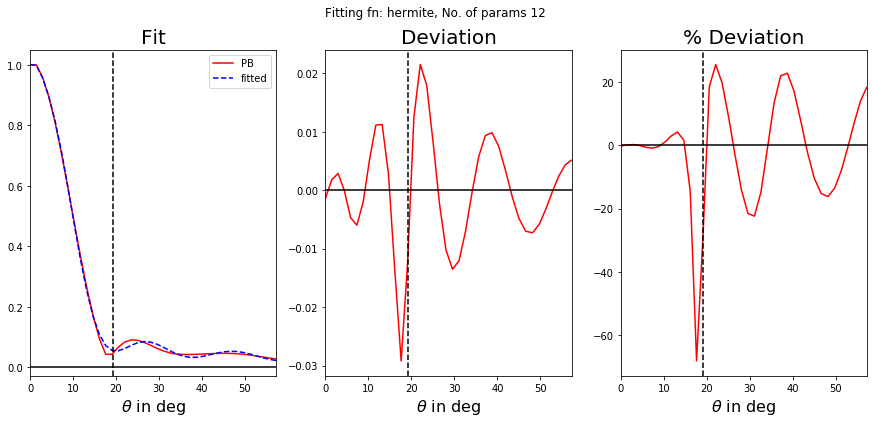

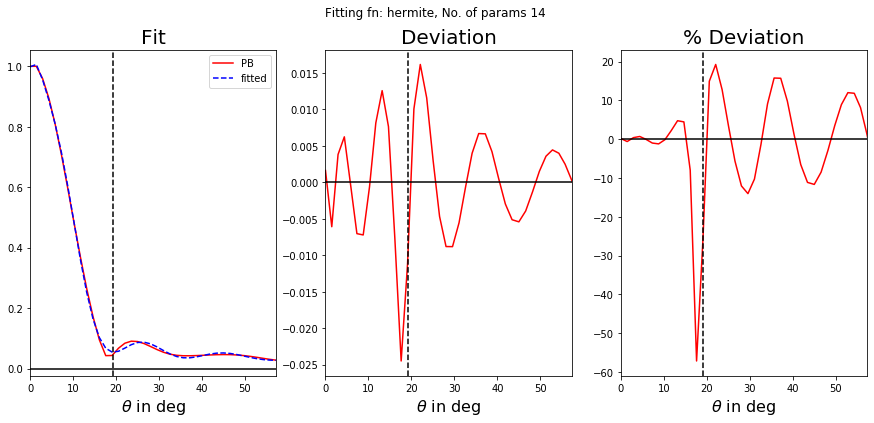

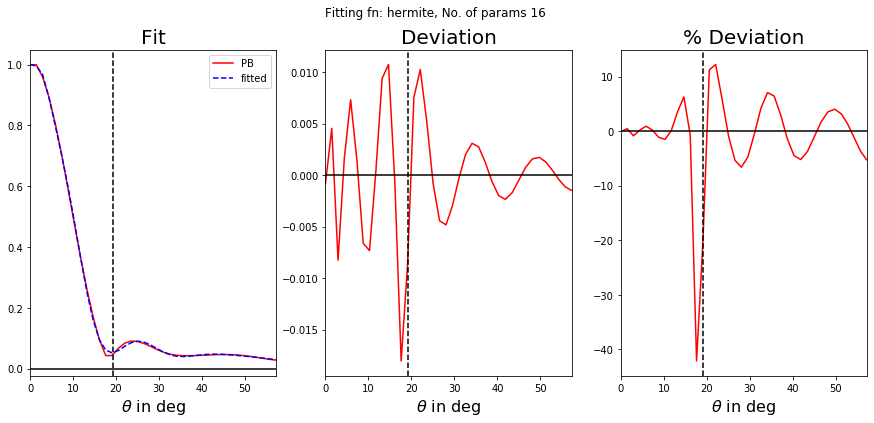

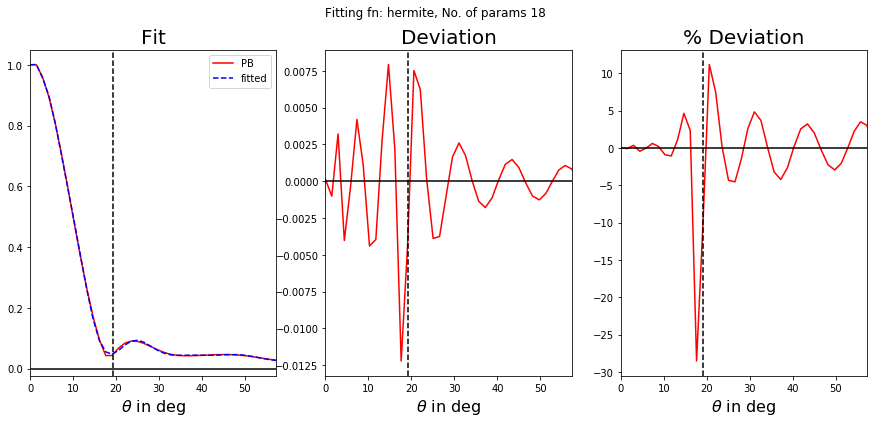

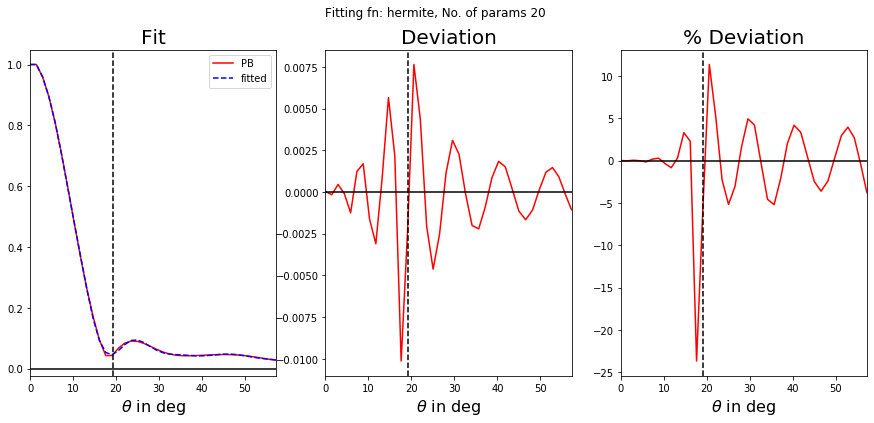

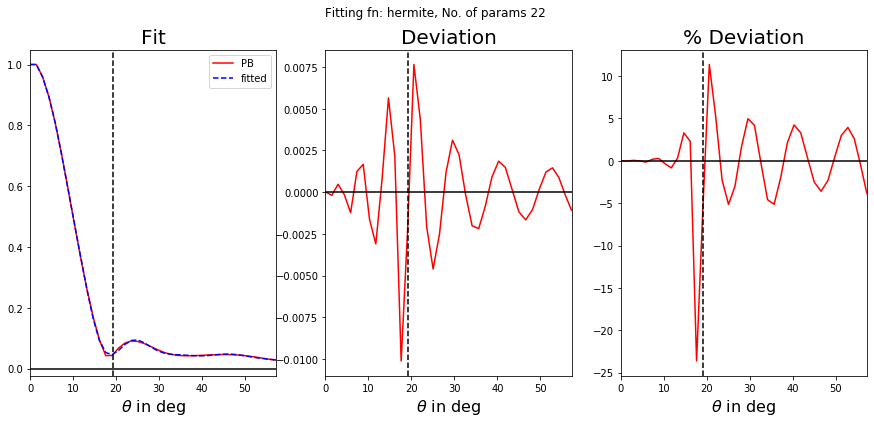

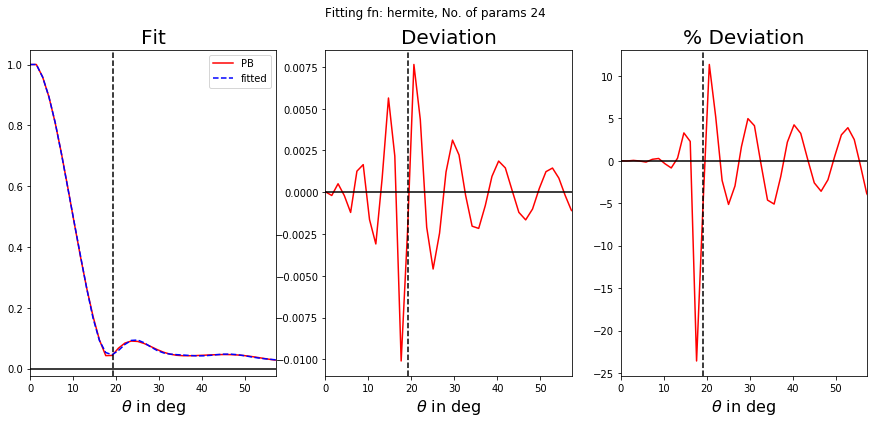

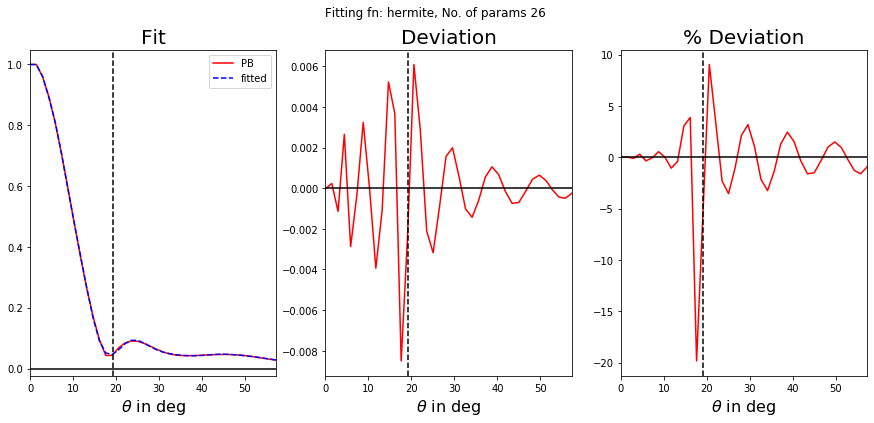

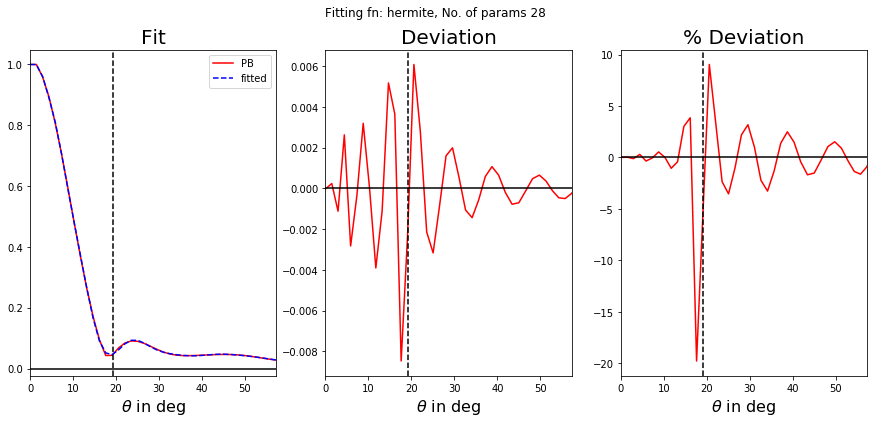

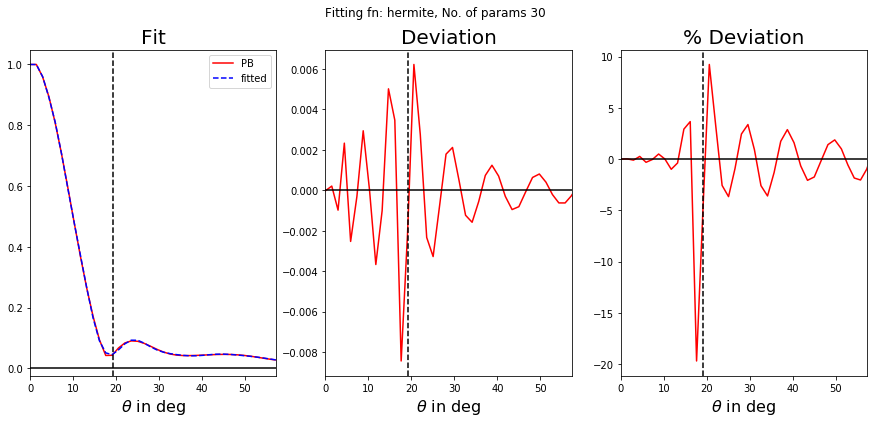

In [9]:
maxher = []
stdher = []
ordher = []
for order in (np.arange(15)*2 + 1):
    fig,max1,std1 = fit_polynomials('hermite', order=order)
    maxher.append(max1)
    stdher.append(std1)
    ordher.append(order)
maxher=np.asarray(maxher)
stdher=np.asarray(stdher)
ordher=np.asarray(ordher)

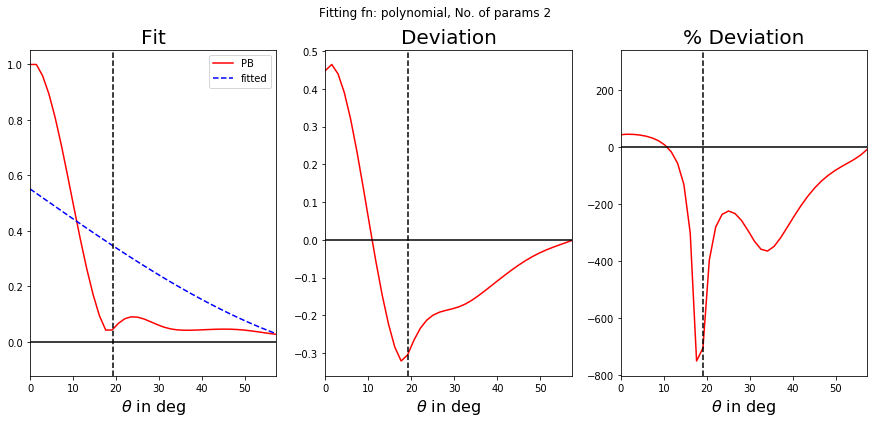

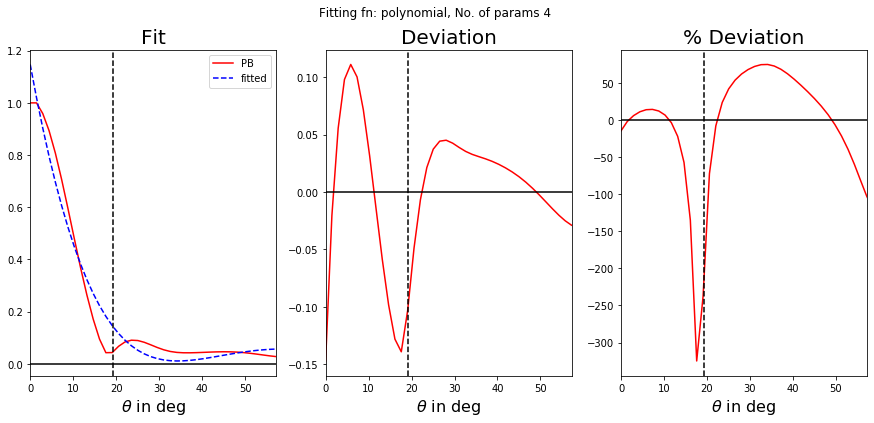

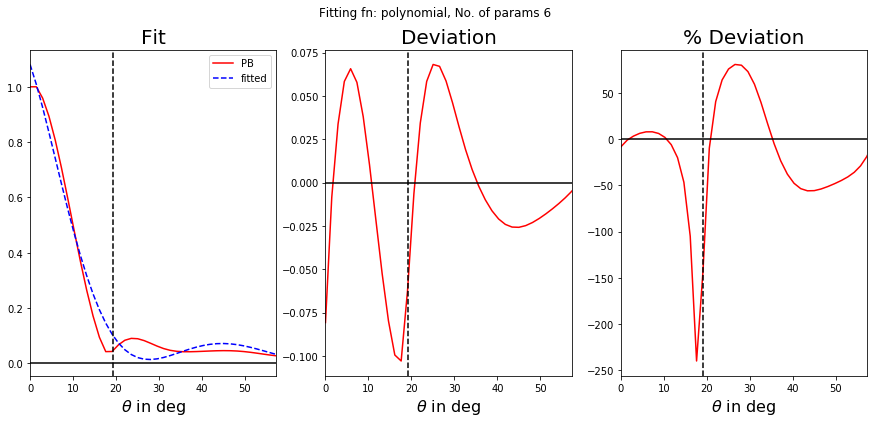

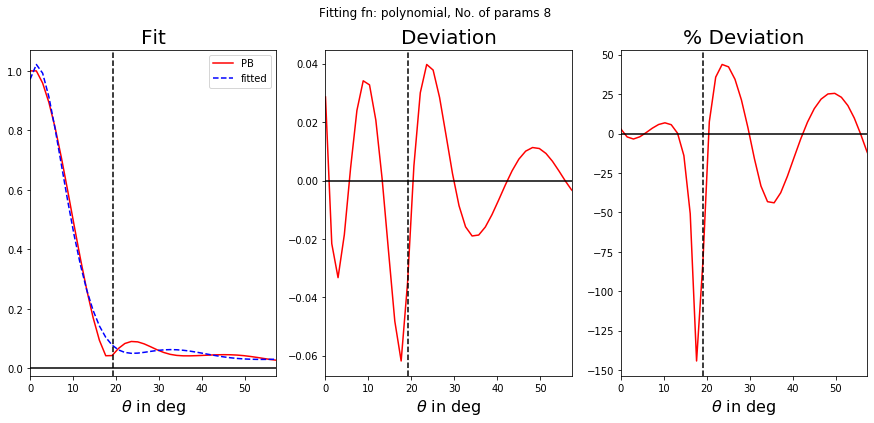

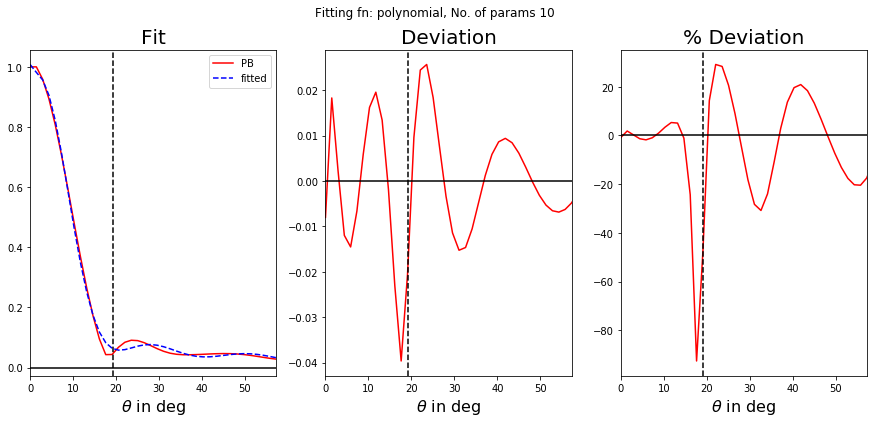

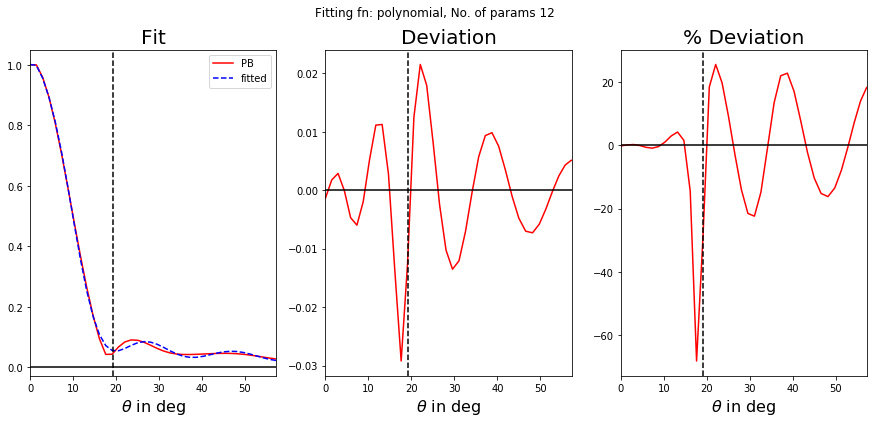

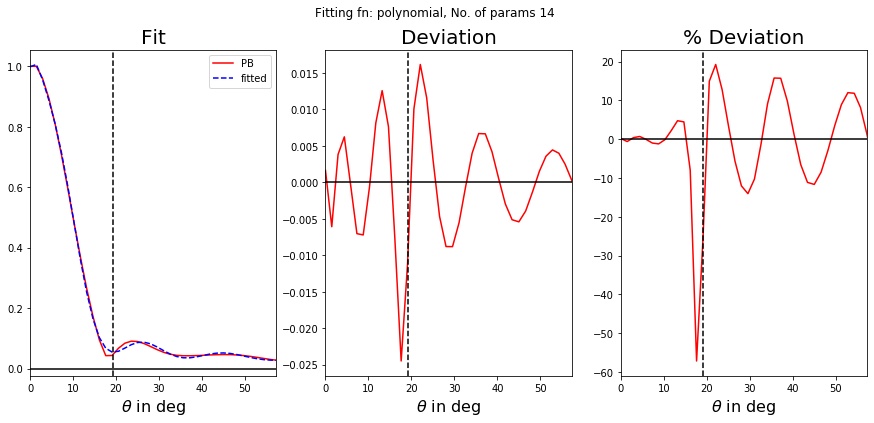

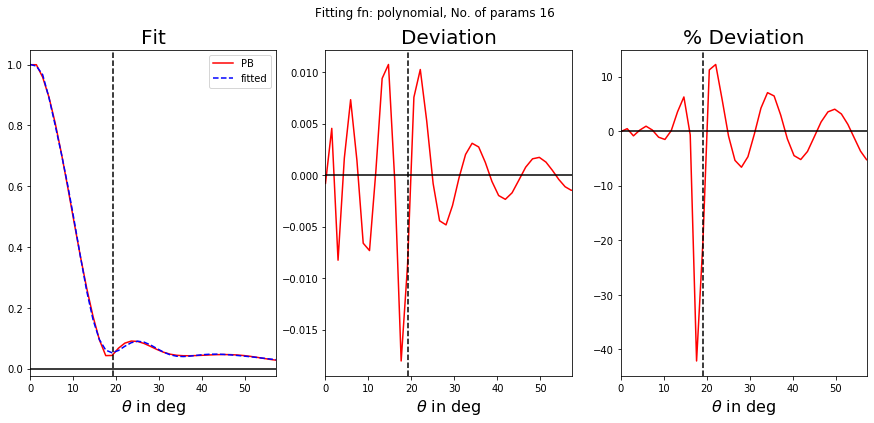

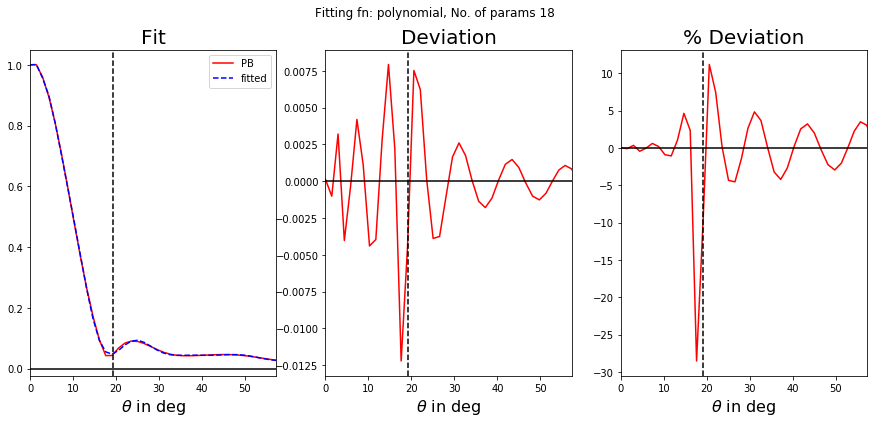

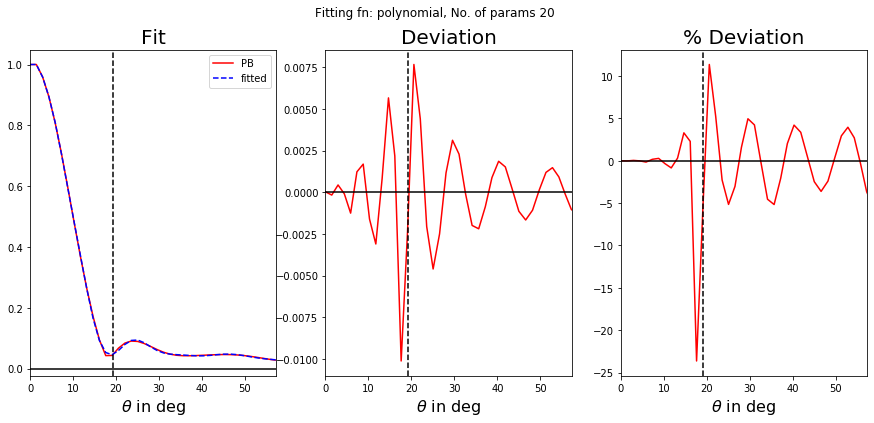

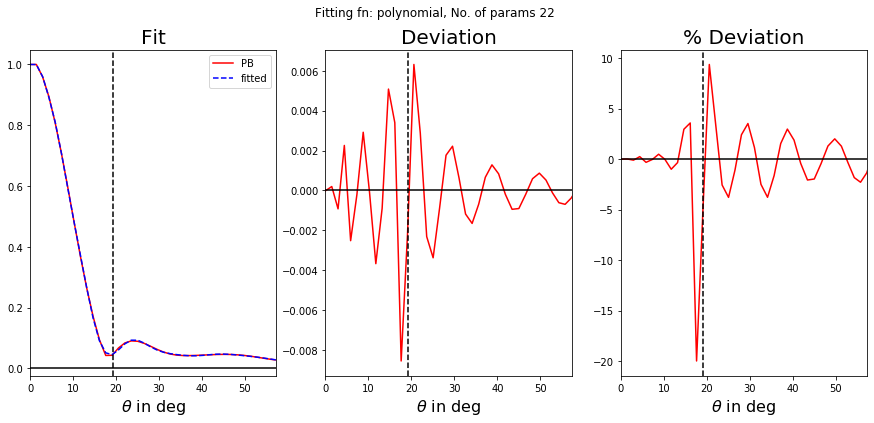

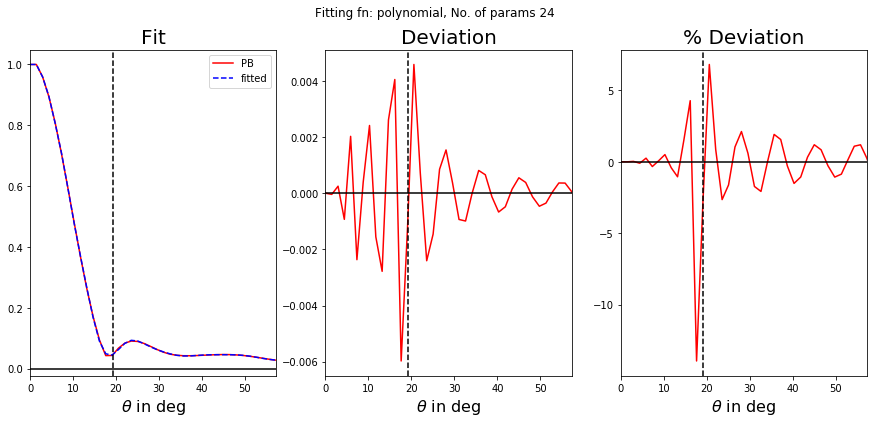

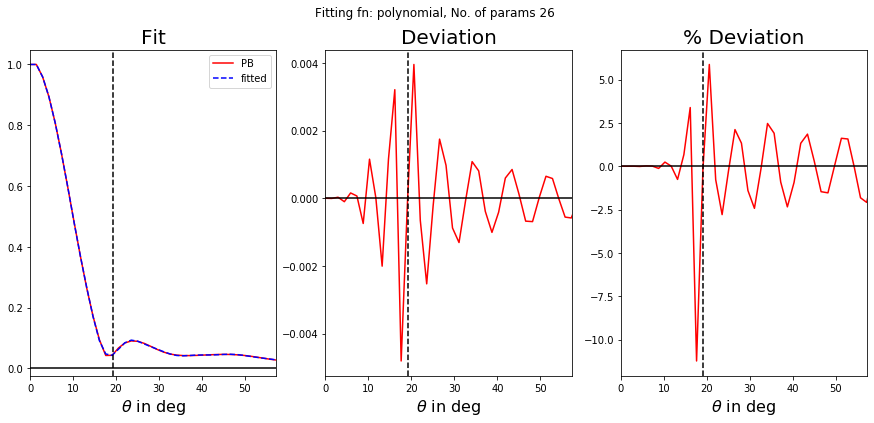

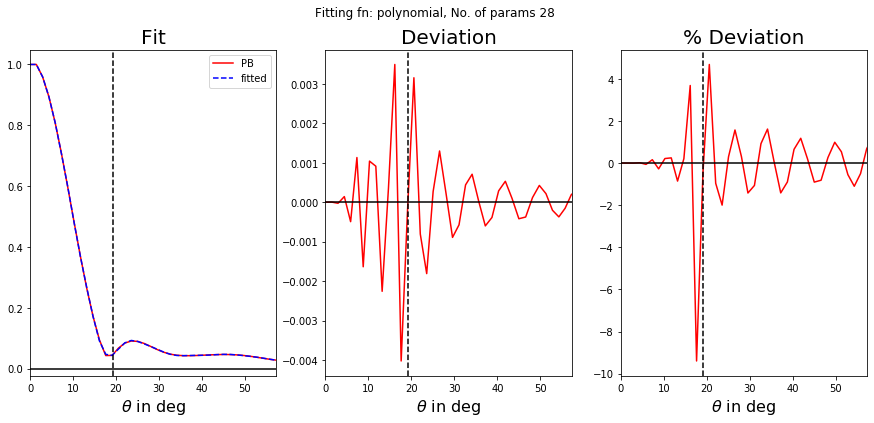

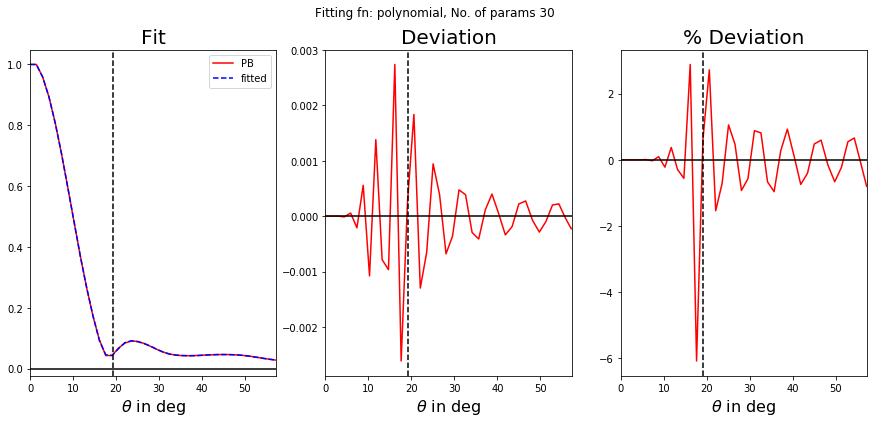

In [10]:
maxpoly = []
stdpoly = []
ordpoly = []
for order in (np.arange(15)*2 + 1):
    fig,max1,std1 = fit_polynomials('polynomial', order=order)
    maxpoly.append(max1)
    stdpoly.append(std1)
    ordpoly.append(order)
maxpoly=np.asarray(maxpoly)
stdpoly=np.asarray(stdpoly)
ordpoly=np.asarray(ordpoly)

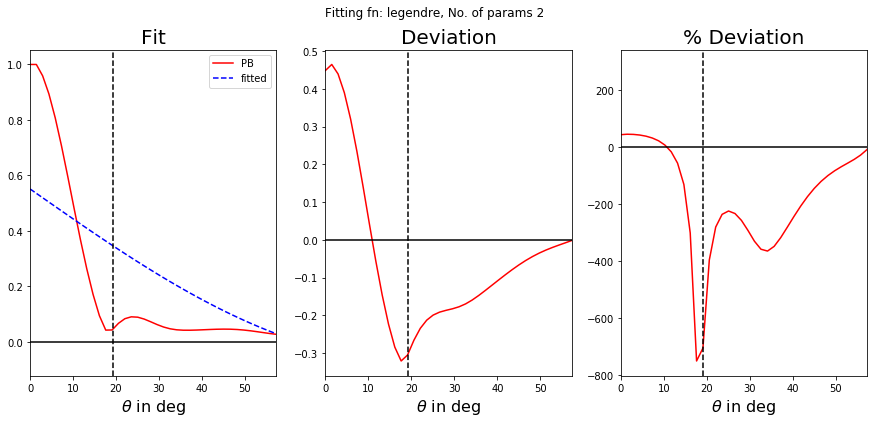

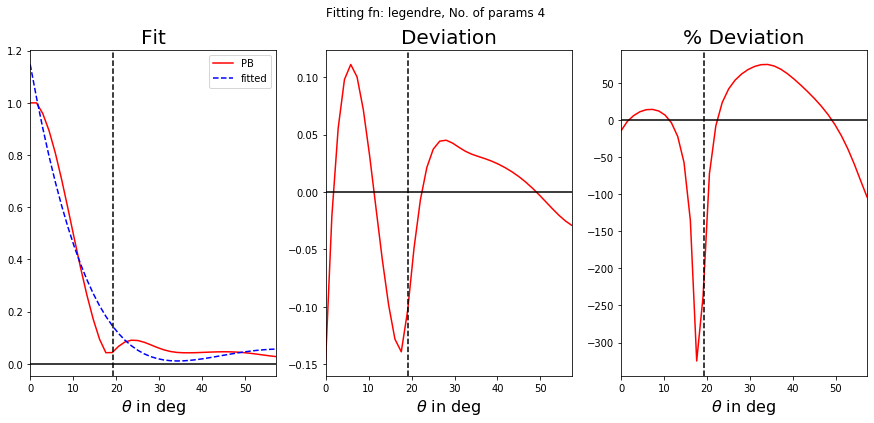

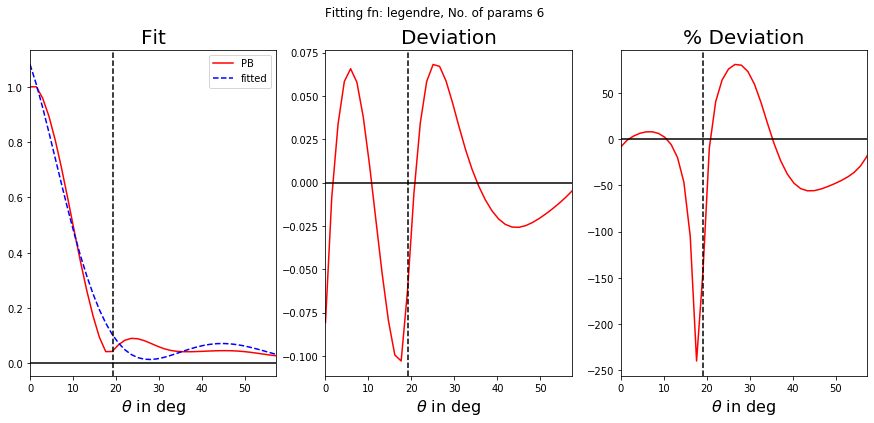

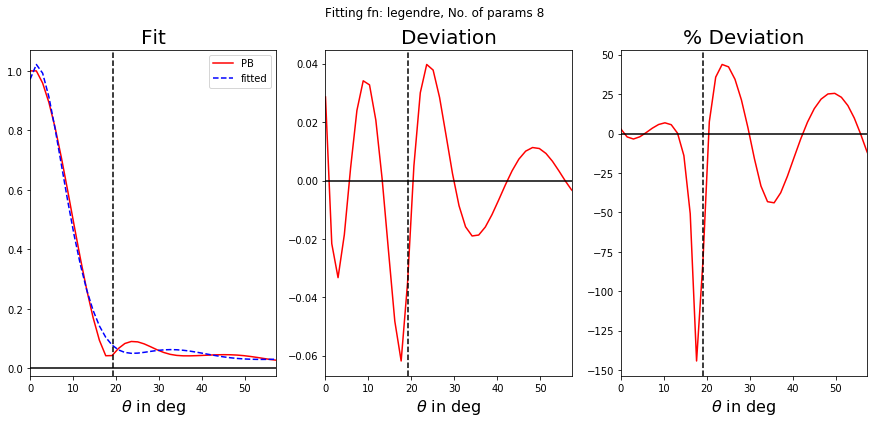

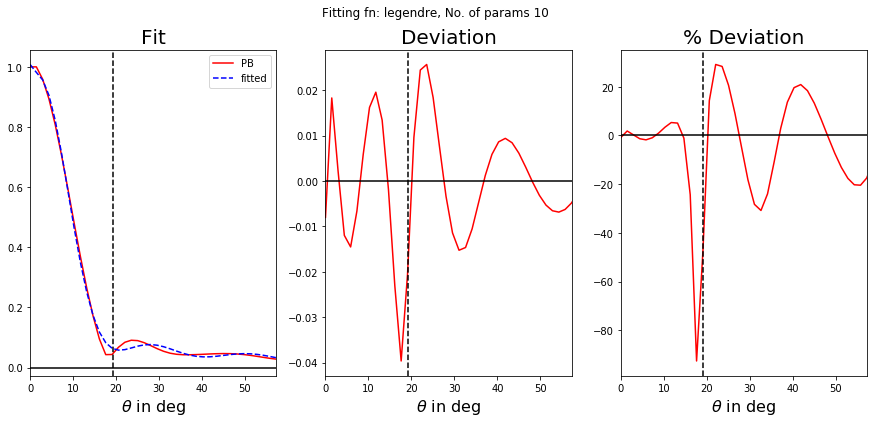

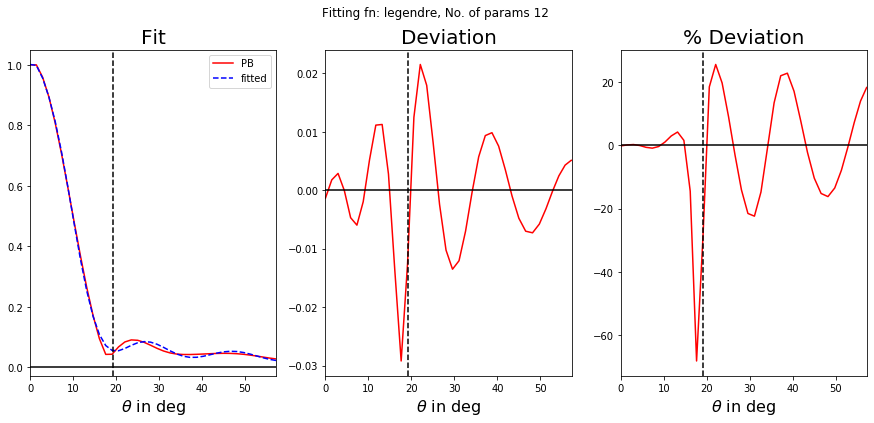

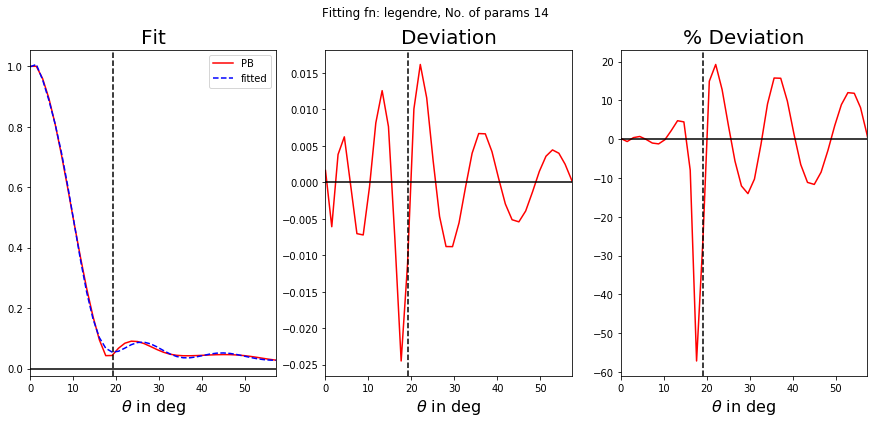

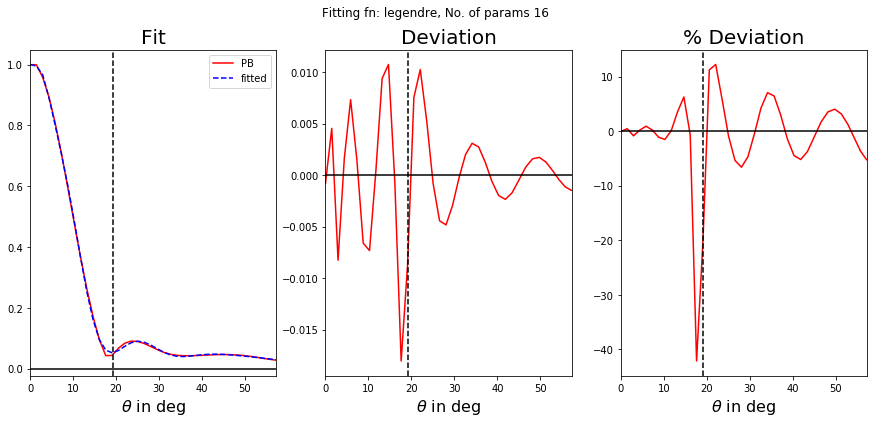

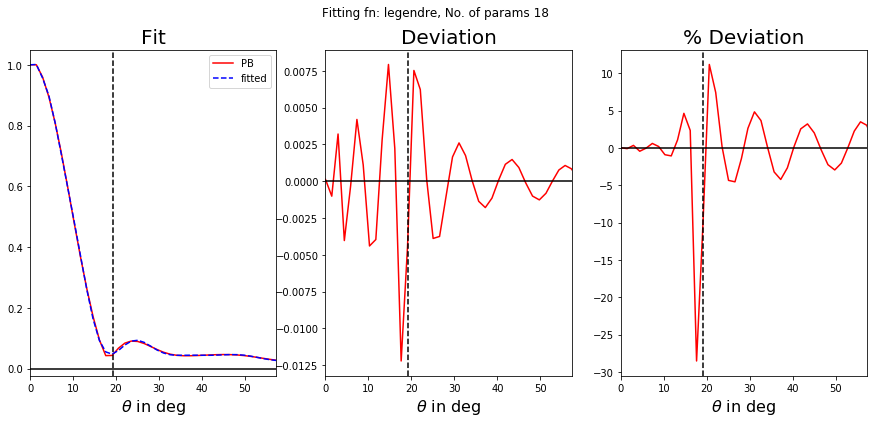

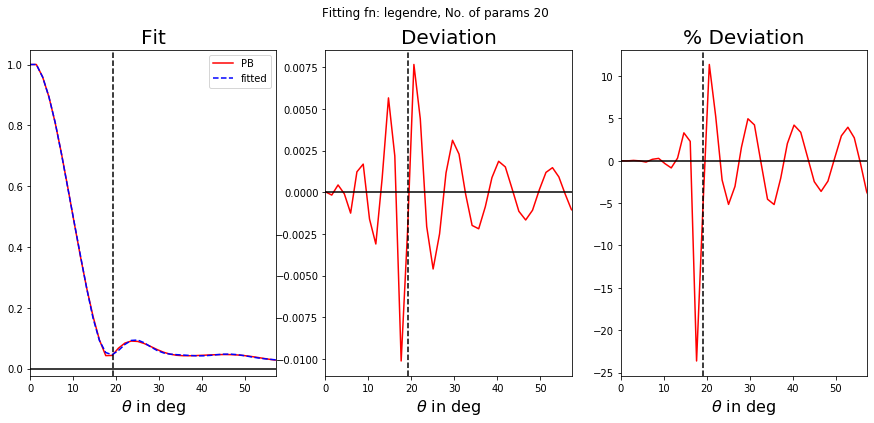

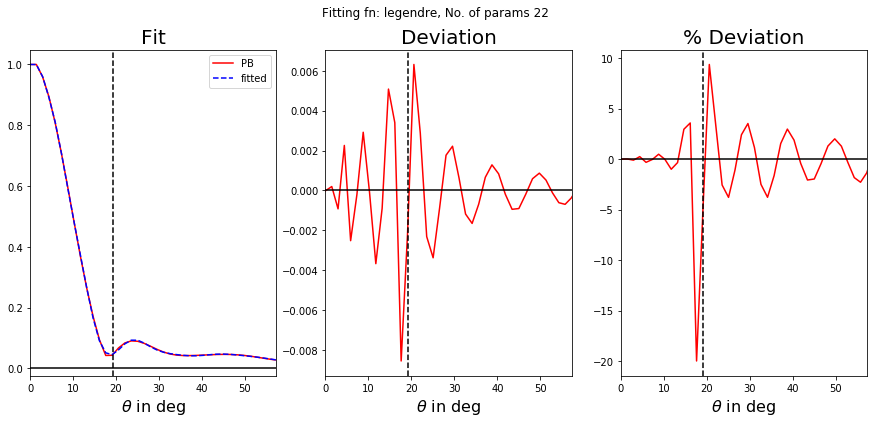

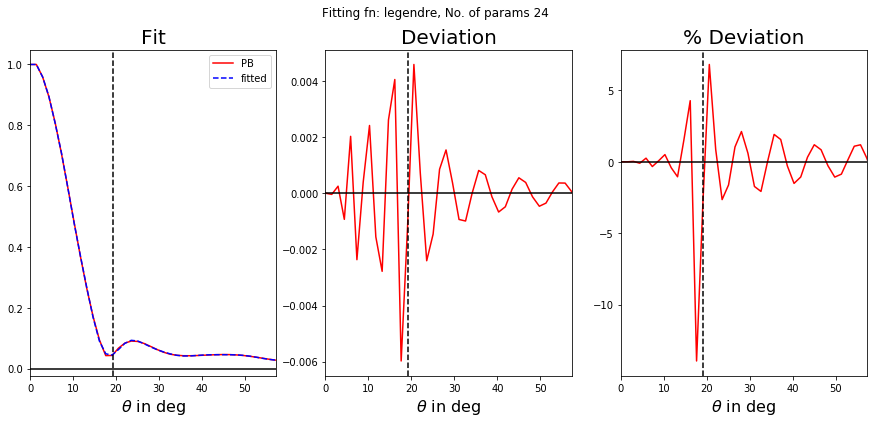

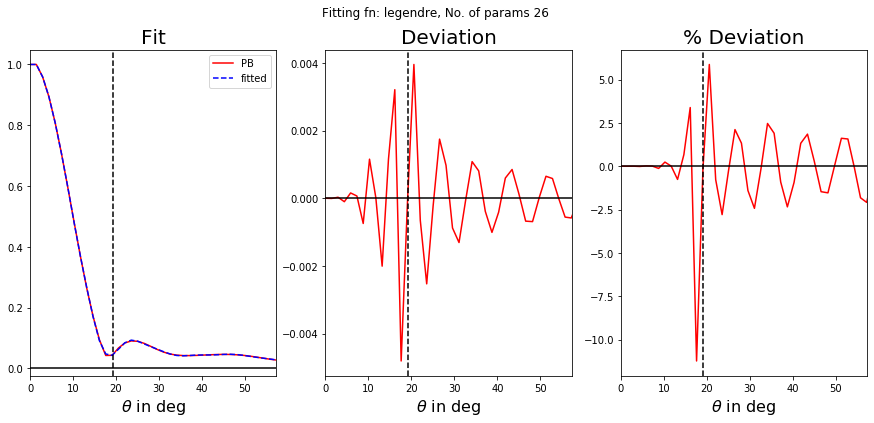

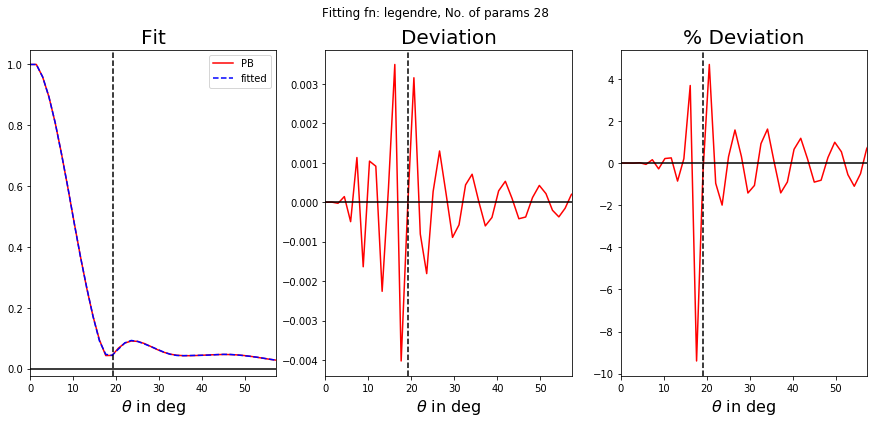

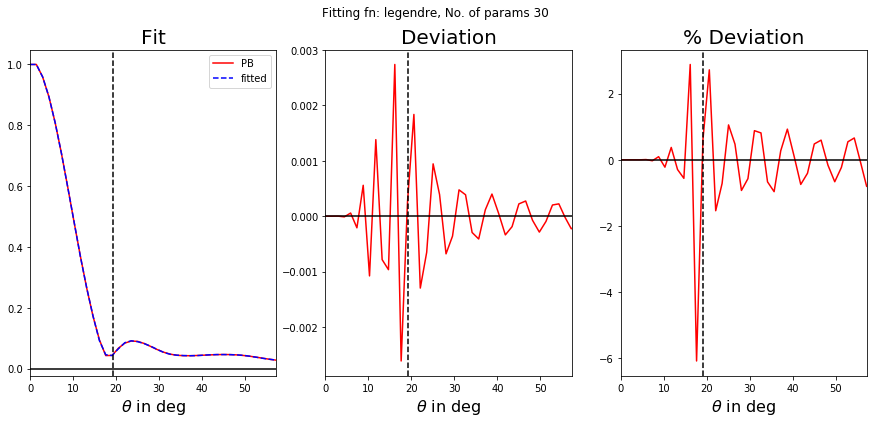

In [11]:
maxleg = []
stdleg = []
ordleg = []
for order in (np.arange(15)*2 + 1):
    fig,max1,std1 = fit_polynomials('legendre', order=order)
    maxleg.append(max1)
    stdleg.append(std1)
    ordleg.append(order)
maxleg=np.asarray(maxleg)
stdleg=np.asarray(stdleg)
ordleg=np.asarray(ordleg)

The fit may be poorly conditioned
The fit may be poorly conditioned
The fit may be poorly conditioned
The fit may be poorly conditioned
The fit may be poorly conditioned
The fit may be poorly conditioned
The fit may be poorly conditioned
The fit may be poorly conditioned
The fit may be poorly conditioned
The fit may be poorly conditioned


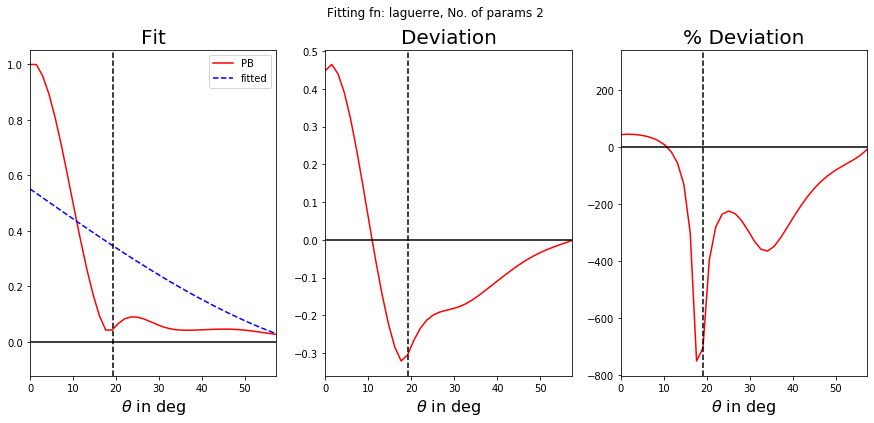

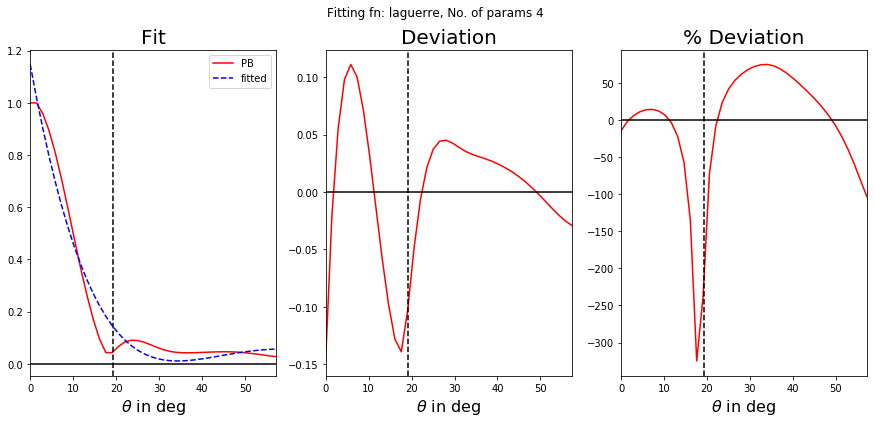

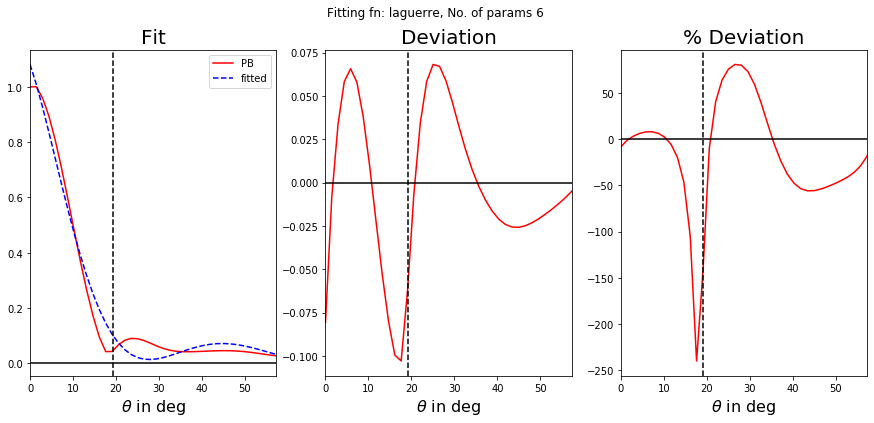

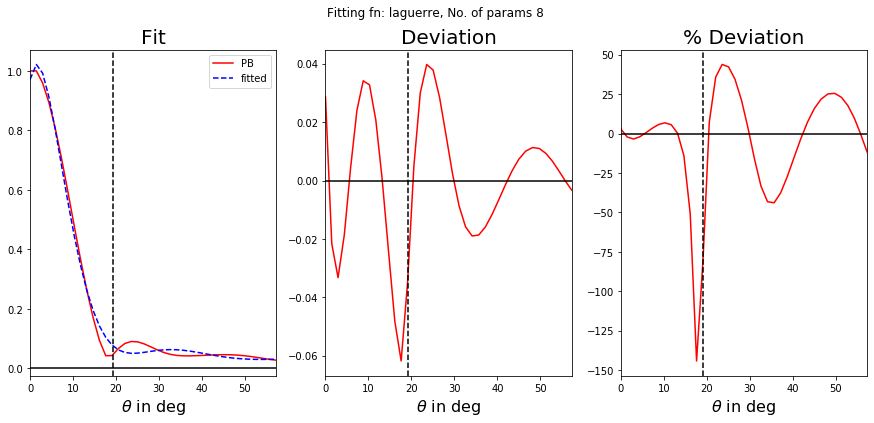

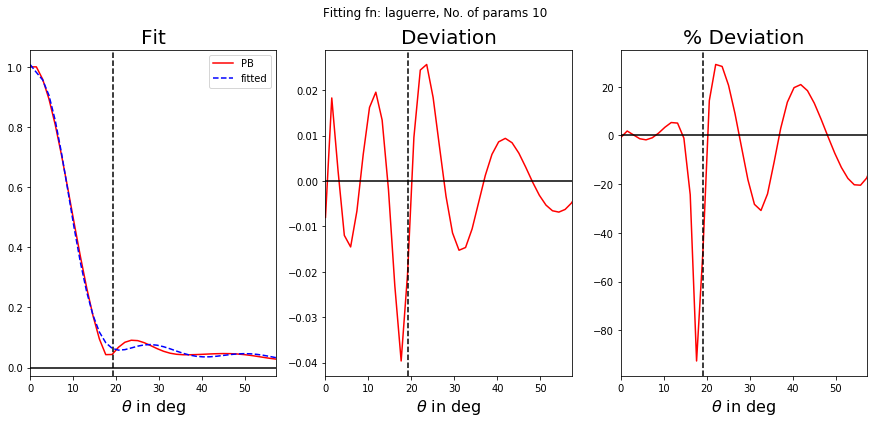

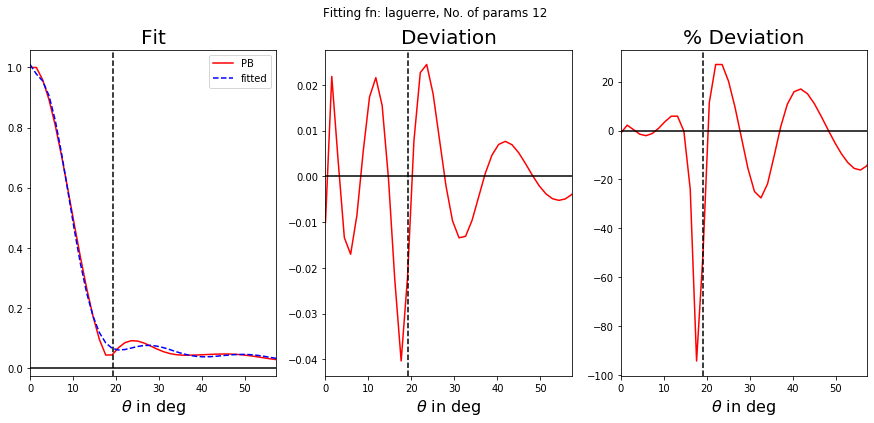

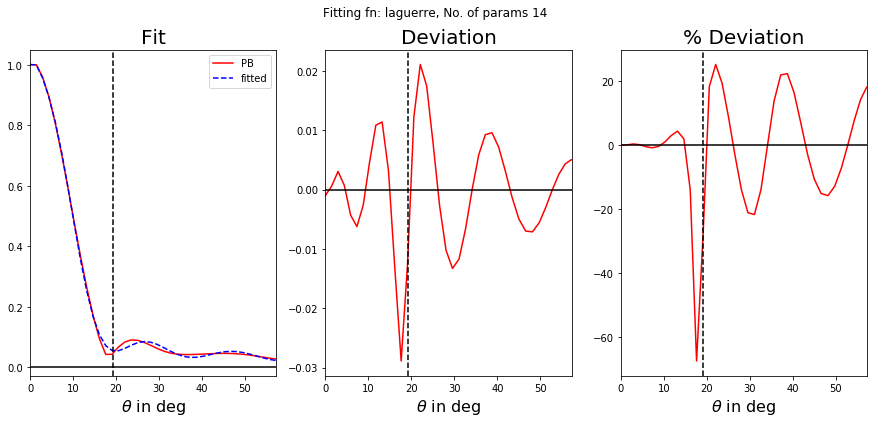

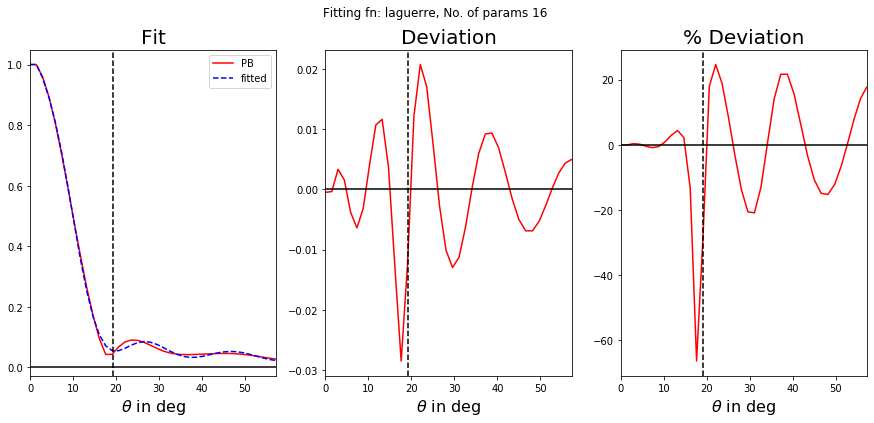

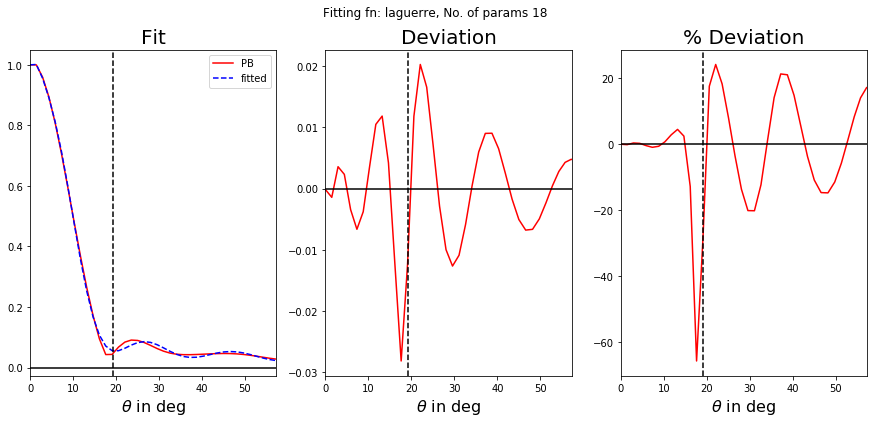

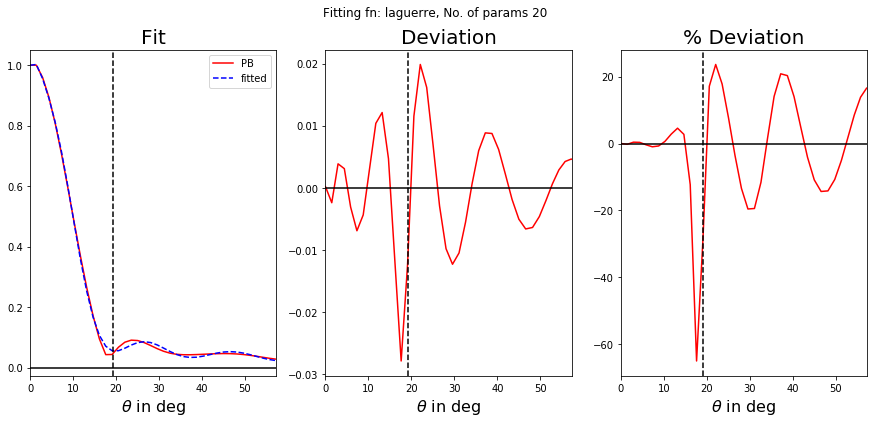

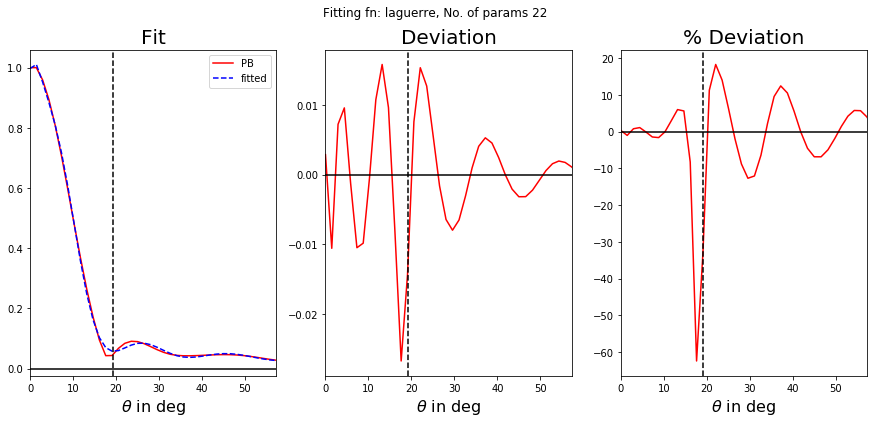

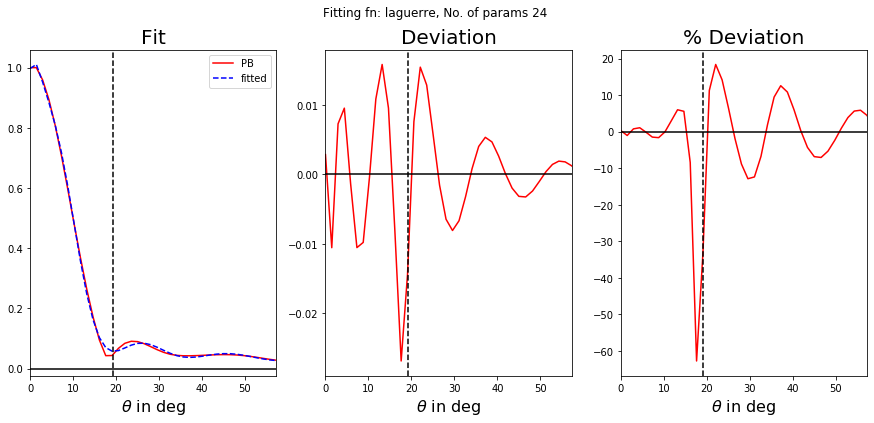

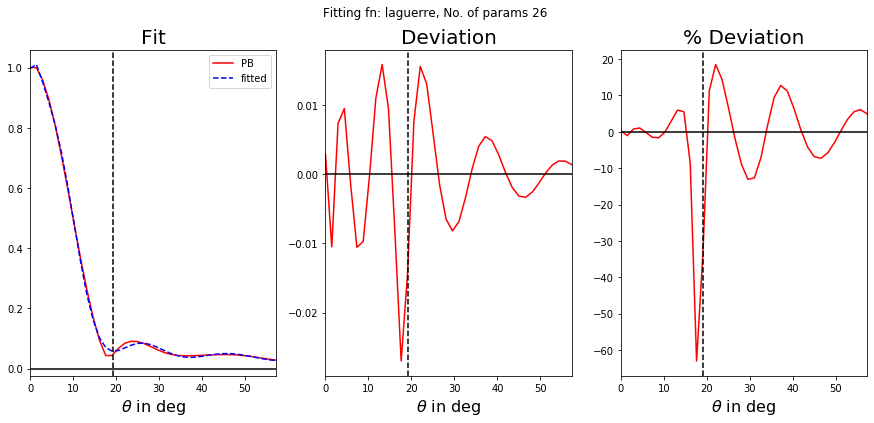

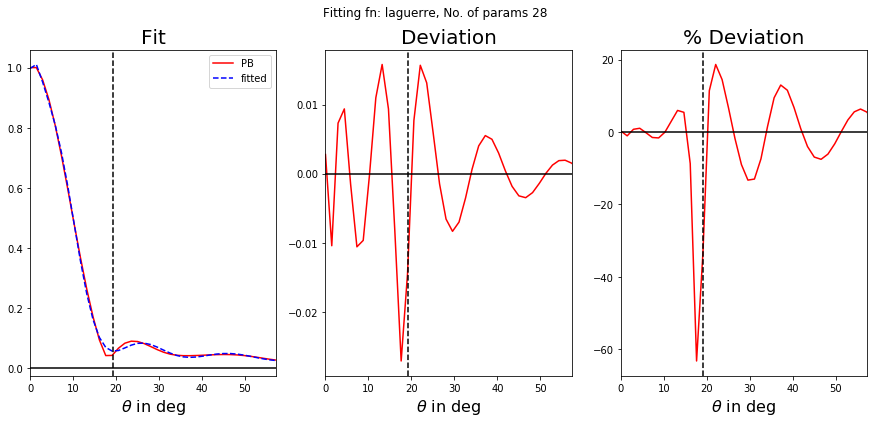

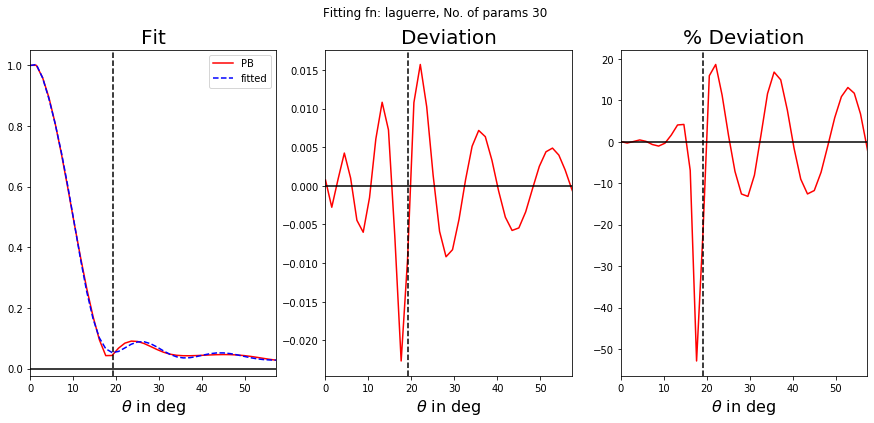

In [12]:
maxlag = []
stdlag = []
ordlag = []
for order in (np.arange(15)*2 + 1):
    fig,max1,std1 = fit_polynomials('laguerre', order=order)
    maxlag.append(max1)
    stdlag.append(std1)
    ordlag.append(order)
maxlag=np.asarray(maxlag)
stdlag=np.asarray(stdlag)
ordlag=np.asarray(ordlag)

In [13]:
def fn(x, *coeffs): 

    y = 0
    N=int(len(coeffs)/2)
    period=np.pi
    for n in range(N):
        
        an= coeffs[n]
        bn= coeffs[n+N]
        y += ( an * np.cos(2.*np.pi*n*x/period) + bn * np.sin(2.*np.pi*n*x/period))
    return y

Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated
Covariance of the parameters could not be estimated


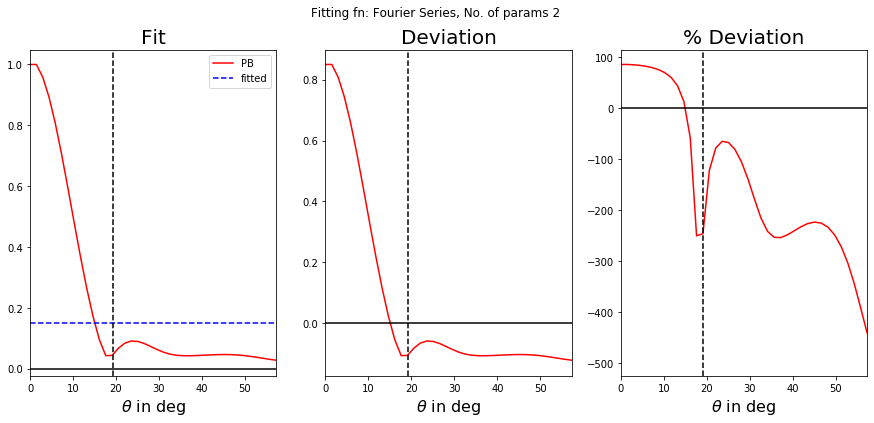

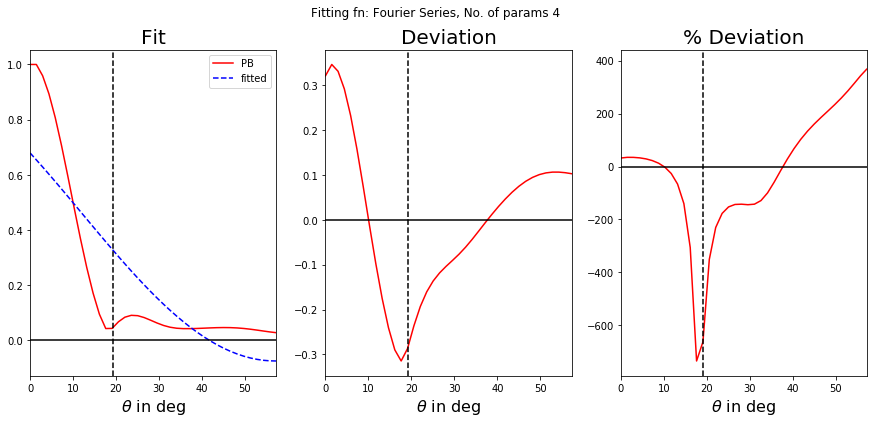

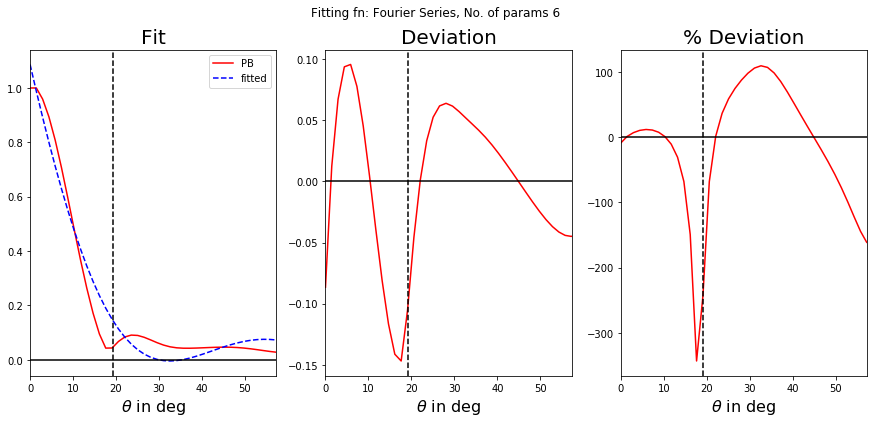

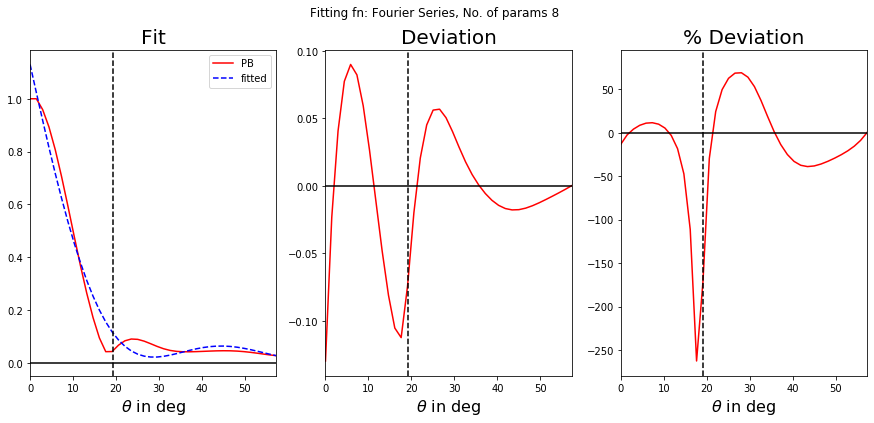

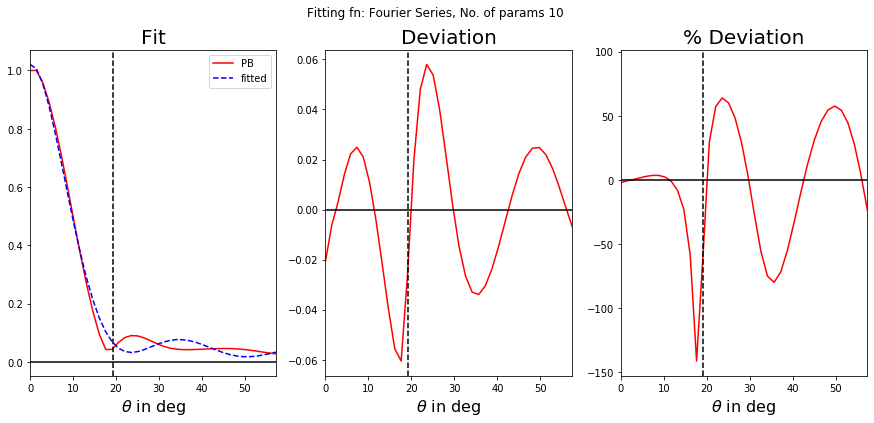

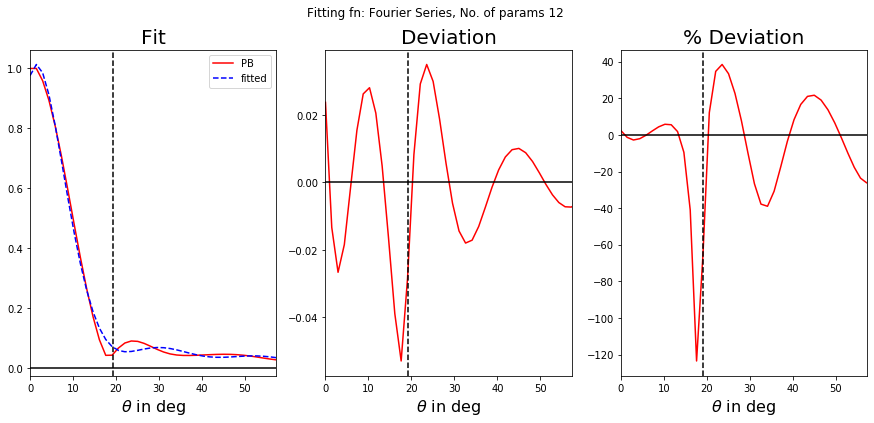

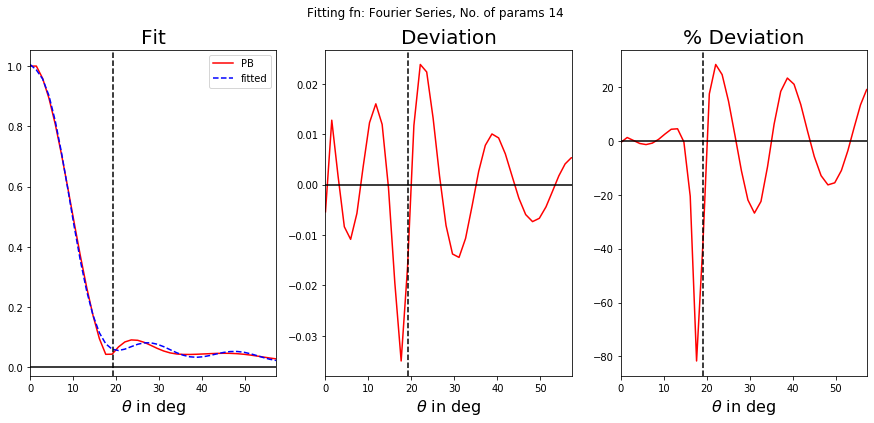

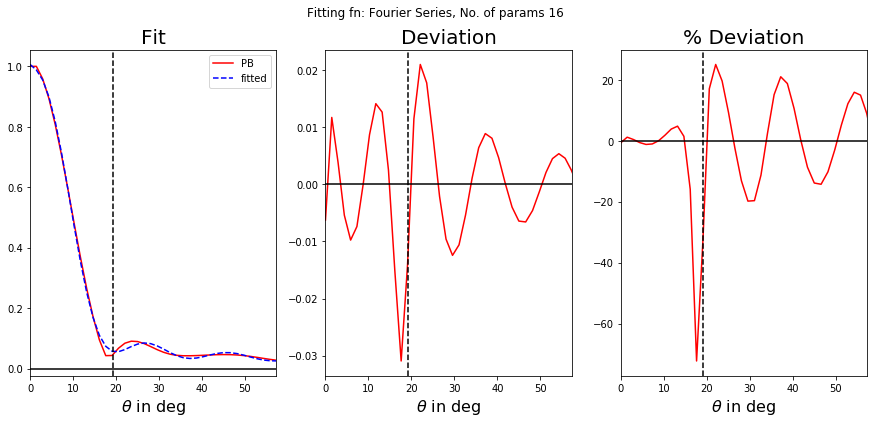

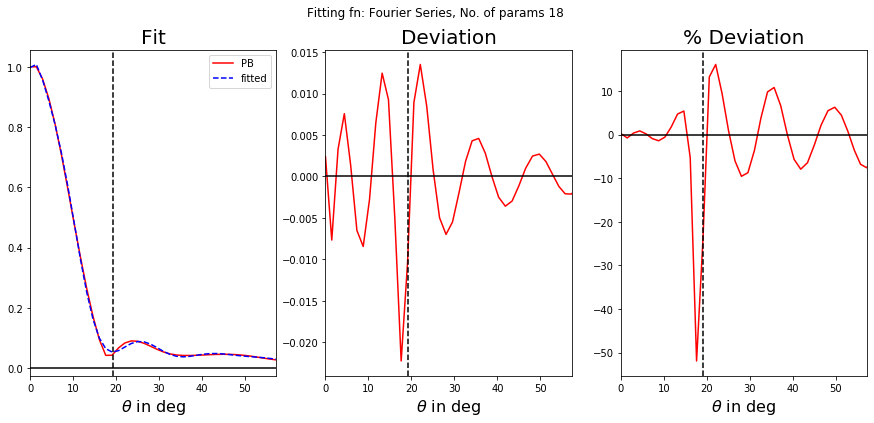

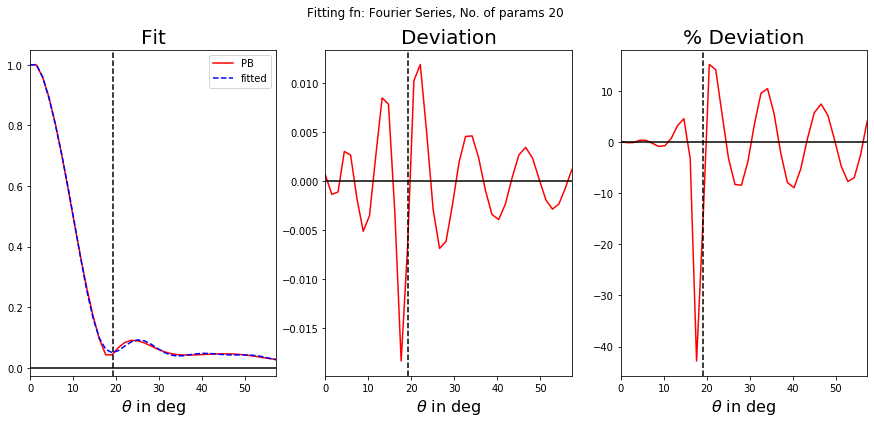

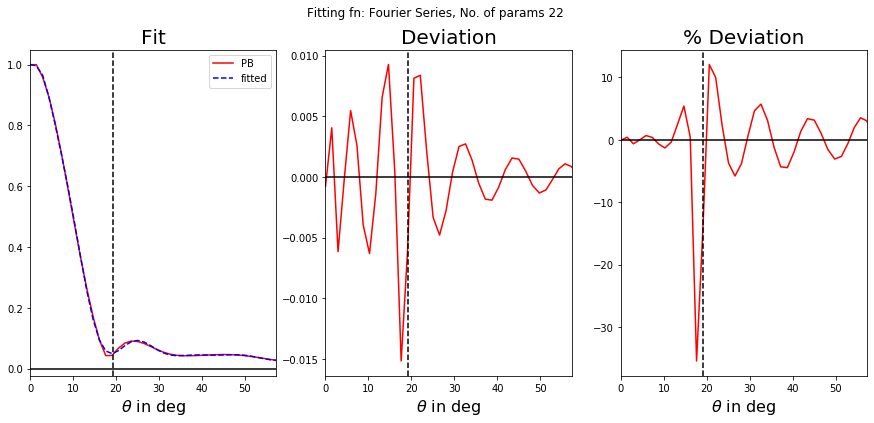

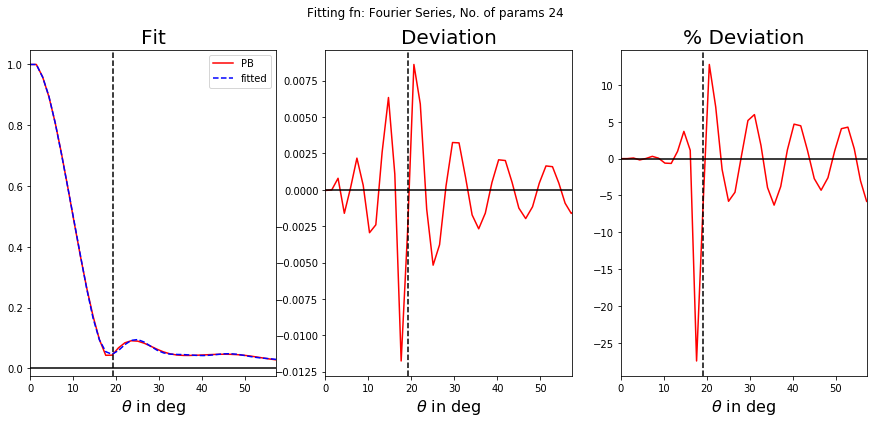

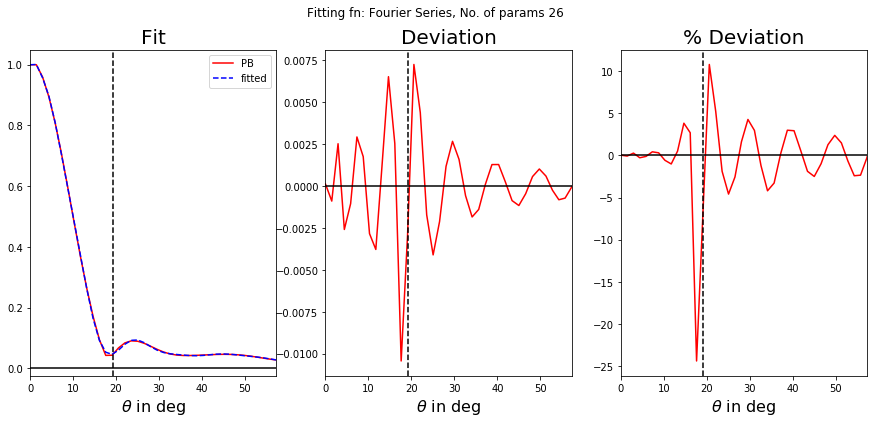

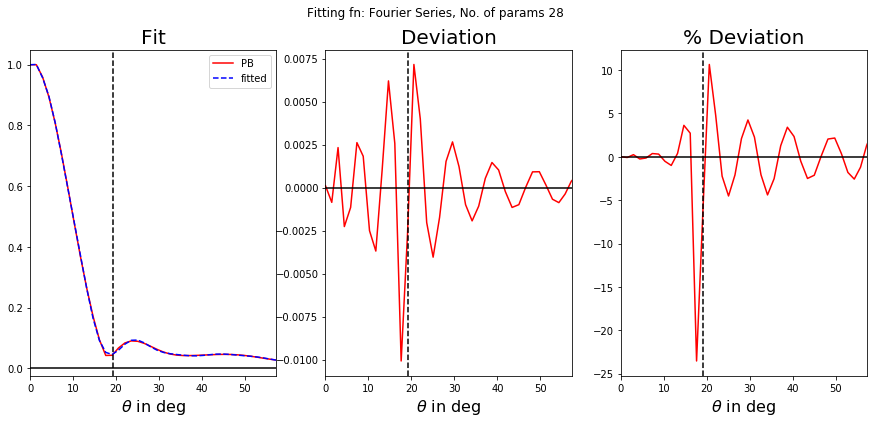

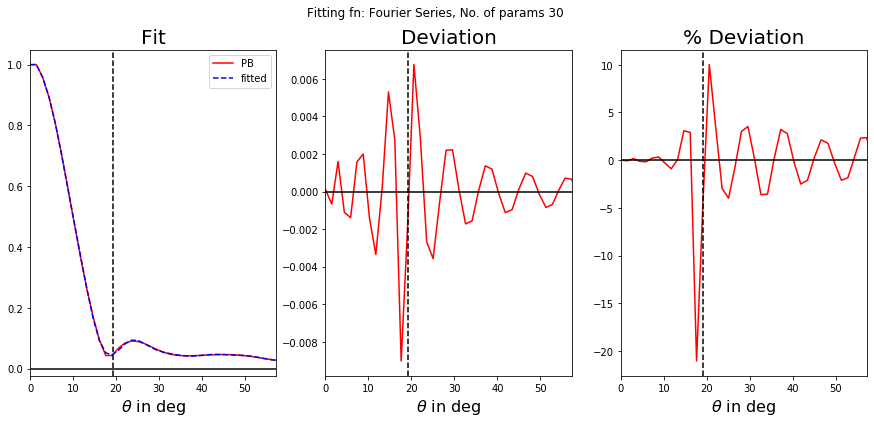

In [14]:
maxfourier = []
stdfourier = []
ordfourier = []
for order in (np.arange(15)*2 + 2):
    initial_coeffs = np.ones(order)
    coeff_fourier,cov_fourier=curve_fit(fn, theta2, pb2, initial_coeffs)
    pb2fit_fourier=fn(theta2,*coeff_fourier)
    perdev_fourier=(1.-pb2fit_fourier/pb2)*100.
    max1=np.max(np.abs(perdev_fourier))
    std1=np.std(perdev_fourier)
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle("Fitting fn: Fourier Series, No. of params %d" % (order))
    
    axes[0].plot(np.rad2deg(theta2), pb2, 'r',label=r'PB')
    axes[0].plot(np.rad2deg(theta2), pb2fit_fourier, 'b--',label=r'fitted')
    axes[0].set_title('Fit', fontsize=20)
    axes[0].axhline(y=0.,c='k')
    axes[0].set_xlim([0.,np.rad2deg(1.)])
    axes[0].axvline(2*HWHM,color='k',ls='--')
    axes[0].set_xlabel(r'$\theta$ in deg', fontsize=16)
    axes[0].legend()

    axes[1].plot(np.rad2deg(theta2), pb2 - pb2fit_fourier,'r')
    axes[1].set_title('Deviation', fontsize=20)
    axes[1].axhline(y=0.,c='k')
    axes[1].set_xlim([0.,np.rad2deg(1.)])
    axes[1].axvline(2*HWHM,color='k',ls='--')
    axes[1].set_xlabel(r'$\theta$ in deg', fontsize=16)
    
    axes[2].plot(np.rad2deg(theta2), perdev_fourier,'r')
    axes[2].set_title('% Deviation', fontsize=20)
    axes[2].axhline(y=0.,c='k')
    axes[2].set_xlim([0.,np.rad2deg(1.)])
    axes[2].axvline(2*HWHM,color='k',ls='--')
    axes[2].set_xlabel(r'$\theta$ in deg', fontsize=16)
    fig.set_size_inches((15., 6.))

    maxfourier.append(max1)
    stdfourier.append(std1)
    ordfourier.append(order)
maxfourier=np.asarray(maxfourier)
stdfourier=np.asarray(stdfourier)
ordfourier=np.asarray(ordfourier)

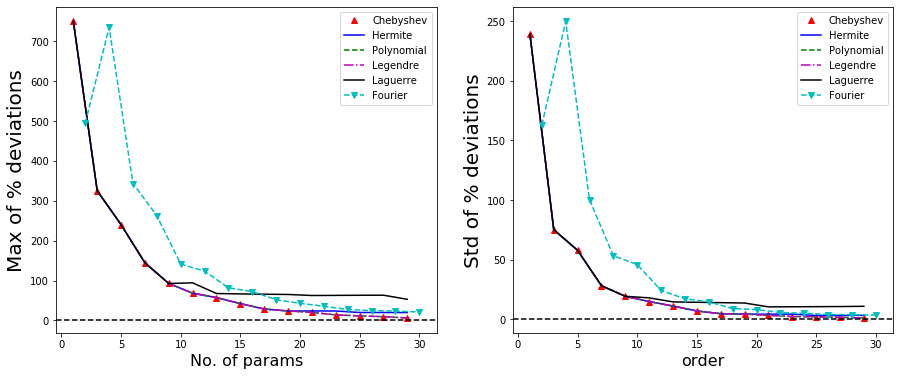

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(ordcheb,maxcheb,'r^',label=r'Chebyshev')
axes[0].plot(ordher,maxher,'b-',label=r'Hermite')
axes[0].plot(ordpoly,maxpoly,'g--',label=r'Polynomial')
axes[0].plot(ordleg,maxleg,'m-.',label=r'Legendre')
axes[0].plot(ordlag,maxlag,'k',label=r'Laguerre')
axes[0].plot(ordfourier,maxfourier,'cv--',label=r'Fourier')
axes[0].set_ylabel('Max of % deviations', fontsize=20)
axes[0].set_xlabel('No. of params',fontsize=16)
axes[0].axhline(y=0.,c='k',ls='--')
axes[0].legend()


axes[1].plot(ordcheb,stdcheb,'r^',label=r'Chebyshev')
axes[1].plot(ordher,stdher,'b-',label=r'Hermite')
axes[1].plot(ordpoly,stdpoly,'g--',label=r'Polynomial')
axes[1].plot(ordleg,stdleg,'m-.',label=r'Legendre')
axes[1].plot(ordlag,stdlag,'k',label=r'Laguerre')
axes[1].plot(ordfourier,stdfourier,'cv--',label=r'Fourier')
axes[1].set_ylabel('Std of % deviations', fontsize=20)
axes[1].set_xlabel('order',fontsize=16)
axes[1].axhline(y=0.,c='k',ls='--')
axes[1].legend()
#plt.savefig('fig_max_std.pdf',bbox_inches='tight')

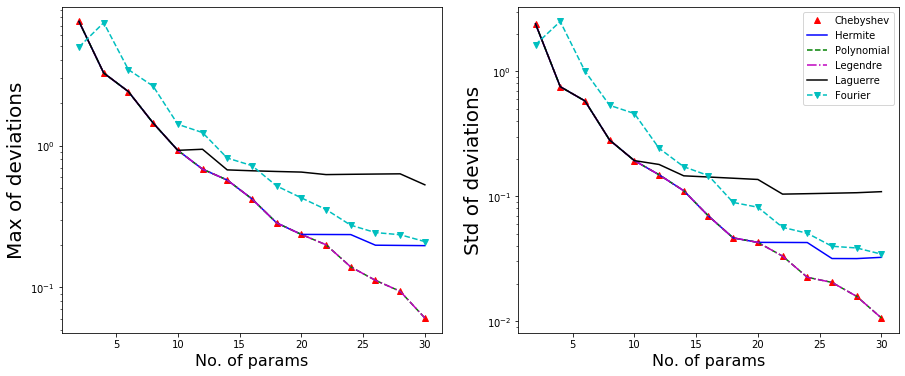

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(ordcheb+1,maxcheb/100.,'r^',label=r'Chebyshev') # No. of params = order +1
axes[0].plot(ordher+1,maxher/100.,'b-',label=r'Hermite')
axes[0].plot(ordpoly+1,maxpoly/100.,'g--',label=r'Polynomial')
axes[0].plot(ordleg+1,maxleg/100.,'m-.',label=r'Legendre')
axes[0].plot(ordlag+1,maxlag/100.,'k',label=r'Laguerre')
axes[0].plot(ordfourier,maxfourier/100.,'cv--',label=r'Fourier')
axes[0].set_ylabel('Max of deviations', fontsize=20)
#axes[0].set_ylim([3.e-3,1.e1])
axes[0].set_xlabel('No. of params',fontsize=16)
#axes[0].axhline(y=0.,c='k',ls='--')
axes[0].set_yscale('log')
#axes[0].legend()


axes[1].plot(ordcheb+1,stdcheb/100.,'r^',label=r'Chebyshev')
axes[1].plot(ordher+1,stdher/100.,'b-',label=r'Hermite')
axes[1].plot(ordpoly+1,stdpoly/100.,'g--',label=r'Polynomial')
axes[1].plot(ordleg+1,stdleg/100.,'m-.',label=r'Legendre')
axes[1].plot(ordlag+1,stdlag/100.,'k',label=r'Laguerre')
axes[1].plot(ordfourier,stdfourier/100.,'cv--',label=r'Fourier')
axes[1].set_ylabel('Std of deviations', fontsize=20)
axes[1].set_xlabel('No. of params',fontsize=16)
#axes[1].set_ylim([1.e-1,1.e3])
#axes[1].axhline(y=0.,c='k',ls='--')
axes[1].set_yscale('log')
axes[1].legend()
plt.savefig('fig_max_stdlog.pdf',bbox_inches='tight')

In [17]:
# order 17, no of params 18
tmptheta1=2.*np.sin(theta1)-1.
tmptheta2=2.*np.sin(theta2)-1.



coeff_tot = numpy.polynomial.chebyshev.chebfit(tmptheta2, pb2, 17) #order = No. of params -1

pb2fit_tot = numpy.polynomial.chebyshev.chebval(tmptheta2, coeff_tot)
pb1fit_tot = numpy.polynomial.chebyshev.chebval(tmptheta1, coeff_tot)

perdev_tot1= (1.-pb1fit_tot/pb1)*100.
perdev_tot= (1.-pb2fit_tot/pb2)*100.

In [18]:
coeff_tot

array([ 0.29778665, -0.44821433,  0.27338272, -0.10030698, -0.01195859,
        0.06063853, -0.04593295,  0.0107879 ,  0.01390283, -0.01881641,
       -0.00177106,  0.01265177, -0.00568299, -0.00333975,  0.00452368,
        0.00151808, -0.00593812,  0.00351559])

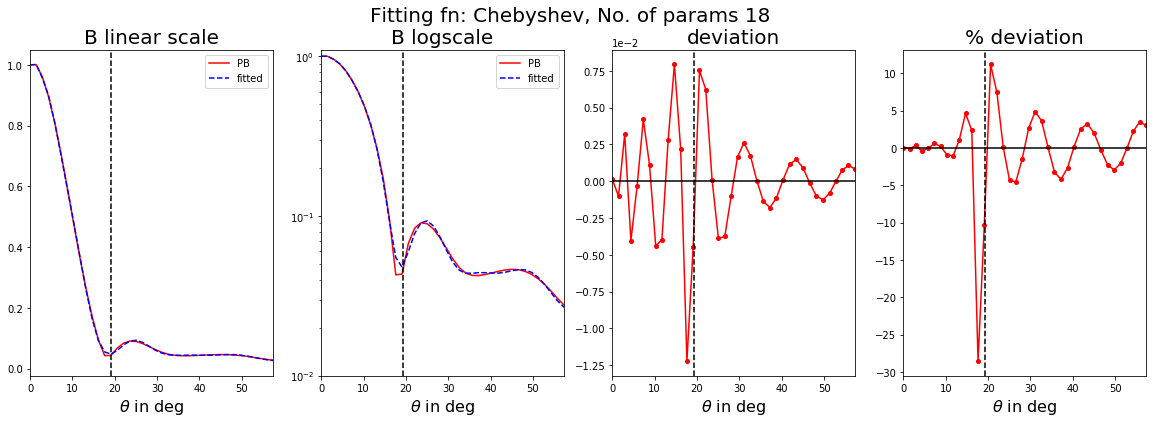

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4))
fig.suptitle("Fitting fn: %s, No. of params %d" % ('Chebyshev', 18), fontsize=20)
axes[0].plot(np.rad2deg(theta2),pb2,'r',label=r'PB')
axes[0].plot(np.rad2deg(theta2),pb2fit_tot,'b--',label=r'fitted')
axes[0].set_title(r'B linear scale', fontsize=20)
axes[0].axvline(2*HWHM,color='k',ls='--')
axes[0].set_xlim([0.,np.rad2deg(1.)])
axes[0].set_xlabel(r'$\theta$ in deg', fontsize=16)
#axes[0].set_ylabel(r'$\sqrt{B}$', fontsize=16)
axes[0].legend()

axes[1].plot(np.rad2deg(theta2),pb2,'r',label=r'PB')
axes[1].plot(np.rad2deg(theta2),pb2fit_tot,'b--',label=r'fitted')
axes[1].set_yscale('log')
axes[1].axvline(2*HWHM,color='k',ls='--')
axes[1].set_xlim([0.,np.rad2deg(1.)])
axes[1].set_ylim([1.e-2,1.1])
axes[1].set_xlabel(r'$\theta$ in deg', fontsize=16)
#axes[1].set_ylabel(r'$\sqrt{B}$', fontsize=16)
axes[1].set_title(r'B logscale', fontsize=20)
axes[1].legend()

axes[2].plot(np.rad2deg(theta2),(pb2-pb2fit_tot),'ro-',ms=4)
axes[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[2].axvline(2*HWHM,color='k',ls='--')
axes[2].set_title('deviation', fontsize=20)
axes[2].set_xlim([0.,np.rad2deg(1.)])
axes[2].set_xlabel(r'$\theta$ in deg', fontsize=16)
#axes[2].set_ylabel(r'deviation', fontsize=16)
axes[2].axhline(y=0.,c='k')

axes[3].plot(np.rad2deg(theta2),perdev_tot,'ro-',ms=4)
axes[3].axvline(2*HWHM,color='k',ls='--')
axes[3].set_title('% deviation', fontsize=20)
axes[3].set_xlim([0.,np.rad2deg(1.)])
axes[3].set_xlabel(r'$\theta$ in deg', fontsize=16)
#axes[3].set_ylabel(r'% deviation', fontsize=16)
#axes[3].set_ylim([-10.,10])
axes[3].axhline(y=0.,c='k')
# Resize plot
fig.set_size_inches((20., 6.))
#plt.savefig('fig_pbavgjoint.pdf',bbox_inches='tight')

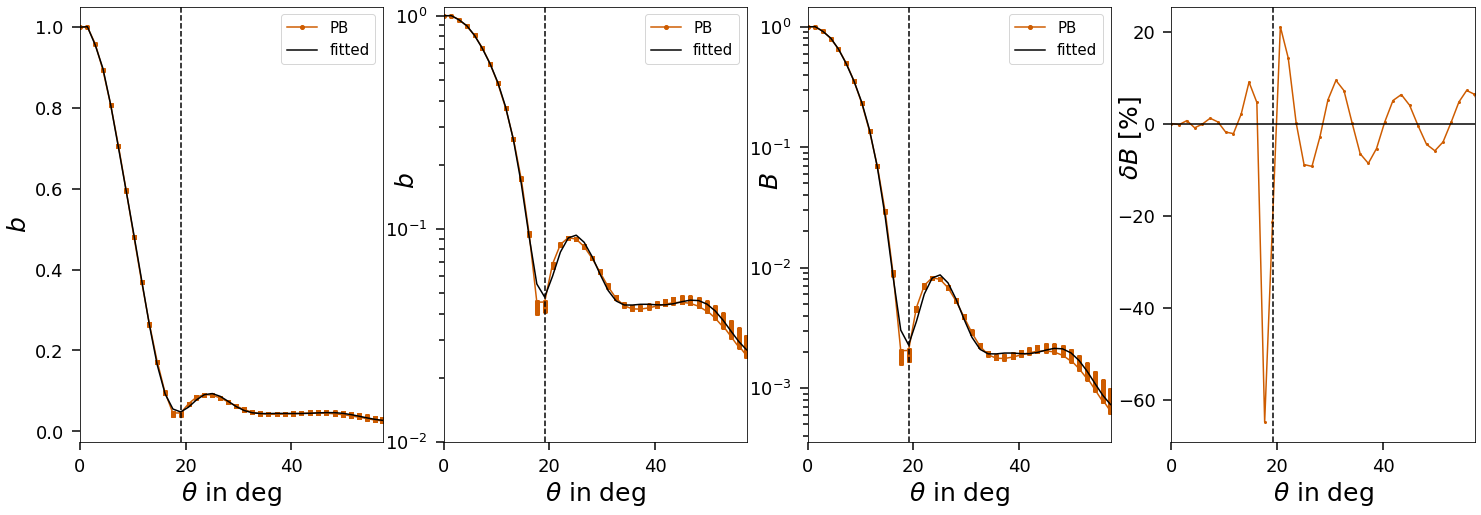

In [54]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4))
#fig.suptitle("%s, No. of params %d" % ('Chebyshev P', 18), fontsize=20)
axes[0].plot(np.rad2deg(theta1),pb1,color='#ce5c00',marker='.',label=r'PB',ms=8)
axes[0].plot(np.rad2deg(theta2),pb2fit_tot,'k-',label=r'fitted')
axes[0].set_ylabel(r'$b$', fontsize=25)
#axes[0].yaxis.set_label_coords(-0.08,0.6)
axes[0].set_xlabel(r'$\theta$ in deg', fontsize=25)
axes[0].axvline(2*HWHM,color='k',ls='--')
axes[0].set_xlim([0.,np.rad2deg(1.)])
axes[0].tick_params(axis='both', which='major', labelsize=18, size=8., width=1.5, pad=8.)
axes[0].tick_params(axis='both', which='minor', labelsize=18, size=5., width=1.5, pad=8.)
axes[0].legend(fontsize=15)

axes[1].plot(np.rad2deg(theta1),pb1,color='#ce5c00',marker='.',label=r'PB',ms=8)
axes[1].plot(np.rad2deg(theta2),pb2fit_tot,'k-',label=r'fitted')
axes[1].set_yscale('log')
axes[1].axvline(2*HWHM,color='k',ls='--')
axes[1].set_xlim([0.,np.rad2deg(1.)])
axes[1].set_ylim([1.e-2,1.1])
axes[1].set_ylabel(r'$b$', fontsize=25)
axes[1].yaxis.set_label_coords(-0.08,0.6)
axes[1].set_xlabel(r'$\theta$ in deg', fontsize=25)
axes[1].tick_params(axis='both', which='major', labelsize=18, size=8., width=1.5, pad=8.)
axes[1].tick_params(axis='both', which='minor', labelsize=18, size=5., width=1.5, pad=8.)
axes[1].legend(fontsize=15)

axes[2].plot(np.rad2deg(theta1),pb_fagnoni1,color='#ce5c00',marker='.',label=r'PB',ms=8)
axes[2].plot(np.rad2deg(theta2),np.square(pb2fit_tot),'k-',label=r'fitted')
axes[2].set_yscale('log')
axes[2].axvline(2*HWHM,color='k',ls='--')
axes[2].set_xlim([0.,np.rad2deg(1.)])
#axes[2].set_ylim([1.e-2,1.1])
axes[2].set_ylabel(r'$B$', fontsize=25)
axes[2].yaxis.set_label_coords(-0.08,0.6)
axes[2].set_xlabel(r'$\theta$ in deg', fontsize=25)
axes[2].tick_params(axis='both', which='major', labelsize=18, size=8., width=1.5, pad=8.)
axes[2].tick_params(axis='both', which='minor', labelsize=18, size=5., width=1.5, pad=8.)
axes[2].legend(fontsize=15)

#axes[2].plot(np.rad2deg(theta2),(pb2-pb2fit_tot),'ro-',ms=4)
#axes[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#axes[2].axvline(2*HWHM,color='k',ls='--')
#axes[2].set_ylabel('deviation', fontsize=20)
#axes[2].set_xlim([0.,np.rad2deg(1.)])
#axes[2].set_xlabel(r'$\theta$ in deg', fontsize=16)
#axes[1,0].set_ylabel(r'deviation', fontsize=16)
#axes[2].axhline(y=0.,c='k')

perdev_square = (1.-np.square(pb2fit_tot)/pb_fagnoni2)*100.
#axes[3].plot(np.rad2deg(theta2),perdev_tot,'ro-',ms=4)
axes[3].plot(np.rad2deg(theta2),perdev_square,color='#ce5c00',marker='.',ms=4)
axes[3].axvline(2*HWHM,color='k',ls='--')
axes[3].set_ylabel('$\delta B~[\%]$', fontsize=25)
axes[3].yaxis.set_label_coords(-0.09,0.7)
axes[3].set_xlim([0.,np.rad2deg(1.)])
axes[3].set_xlabel(r'$\theta$ in deg', fontsize=25)
axes[3].axhline(y=0.,c='k')
axes[3].tick_params(axis='both', which='major', labelsize=18, size=8., width=1.5, pad=8.)
axes[3].tick_params(axis='both', which='minor', labelsize=18, size=5., width=1.5, pad=8.)
# Resize plot
fig.set_size_inches((25., 8.))
plt.savefig('fig_pbavgjoint.pdf',bbox_inches='tight')

In [21]:
np.rad2deg(theta2[11:15]),pb2fit_tot[11:15]

(array([16.13450391, 17.61243907, 19.09333336, 20.57745351]),
 array([0.09257339, 0.05504456, 0.04779786, 0.05985881]))

In [22]:
np.rad2deg(theta2[23:26]),pb2fit_tot[23:26]

(array([34.12664956, 35.6590877 , 37.19814622]),
 array([0.04387638, 0.04384658, 0.04419978]))

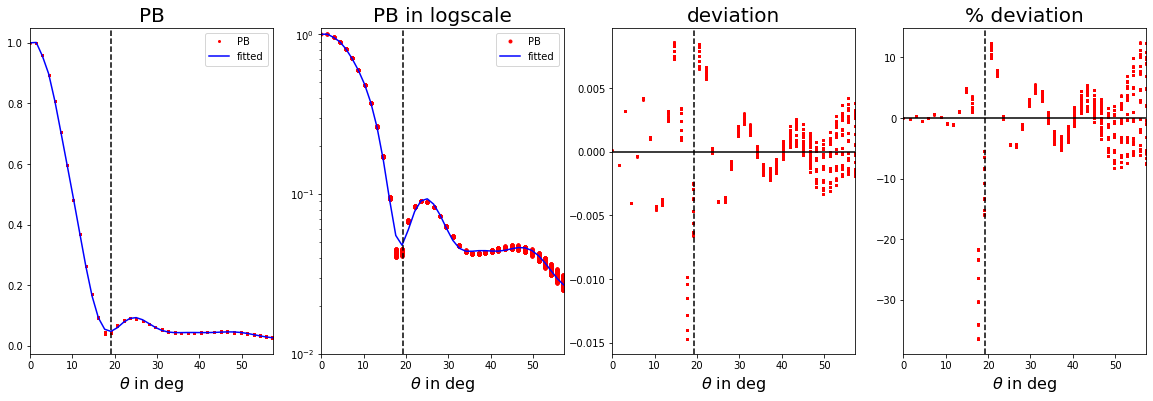

In [23]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4))
axes[0].plot(np.rad2deg(theta1),pb1,'r.',label=r'PB',ms=4)
axes[0].plot(np.rad2deg(theta2),pb2fit_tot,'b',label=r'fitted')
axes[0].set_title('PB', fontsize=20)
axes[0].axvline(2*HWHM,color='k',ls='--')
axes[0].set_xlim([0.,np.rad2deg(1.0)])
axes[0].set_xlabel(r'$\theta$ in deg', fontsize=16)
axes[0].legend()

axes[1].plot(np.rad2deg(theta1),pb1,'r.',label=r'PB')
axes[1].plot(np.rad2deg(theta2),pb2fit_tot,'b',label=r'fitted')
axes[1].set_yscale('log')
axes[1].axvline(2*HWHM,color='k',ls='--')
axes[1].set_xlim([0.,np.rad2deg(1.)])
axes[1].set_ylim([1.e-2,1.1])
axes[1].set_xlabel(r'$\theta$ in deg', fontsize=16)
axes[1].set_title('PB in logscale', fontsize=20)
axes[1].legend()


axes[2].plot(np.rad2deg(theta1),pb1-pb1fit_tot,'r.',ms=4)
axes[2].axvline(2*HWHM,color='k',ls='--')
axes[2].set_title('deviation', fontsize=20)
axes[2].set_xlim([0.,np.rad2deg(1.)])
axes[2].set_xlabel(r'$\theta$ in deg', fontsize=16)
axes[2].axhline(y=0.,c='k')

axes[3].plot(np.rad2deg(theta1),perdev_tot1,'r.',ms=4)
axes[3].axvline(2*HWHM,color='k',ls='--')
axes[3].set_title('% deviation', fontsize=20)
axes[3].set_xlim([0.,np.rad2deg(1.)])
axes[3].set_xlabel(r'$\theta$ in deg', fontsize=16)
#axes[3].set_ylim([-10.,10])
axes[3].axhline(y=0.,c='k')
# Resize plot
fig.set_size_inches((20., 6.))
plt.savefig('fig_pbnoavgjoint.pdf',bbox_inches='tight')

invalid value encountered in true_divide


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 90 deg 0.00'.


divide by zero encountered in log10


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 90 deg 0.00'.


invalid value encountered in less_equal
invalid value encountered in less
invalid value encountered in greater


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 90 deg 0.00'.


invalid value encountered in less
invalid value encountered in greater


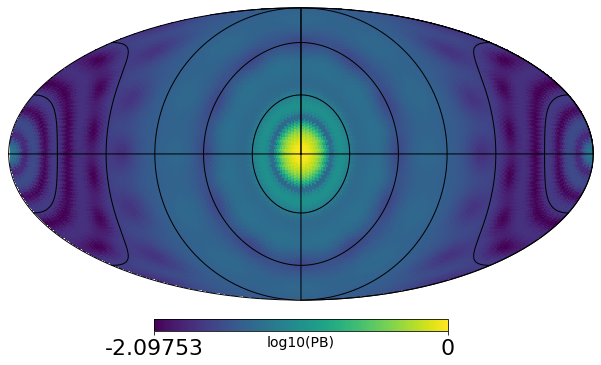

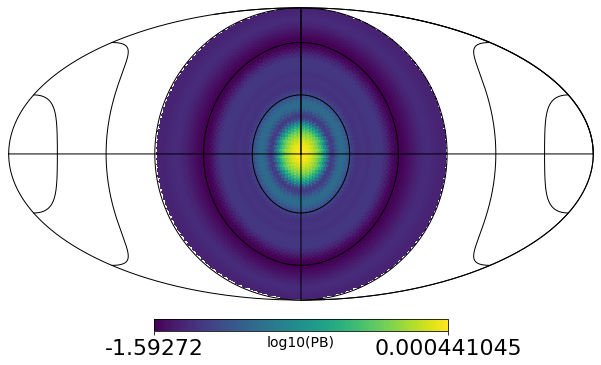

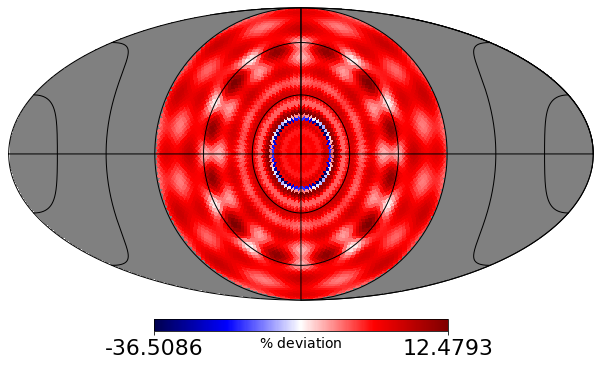

In [24]:
pbuptopi=np.where(theta >= np.pi/2, 0., pb)
pbfitcheb_hp=np.zeros(Npixels)

for n,th in enumerate(theta2):
    pbfitcheb_hp[np.where(theta==th)]=pb2fit_tot[n]
    
reshp=(pbuptopi-pbfitcheb_hp)*100./pbuptopi

matplotlib.rcParams.update({'font.size':22})
hp.mollview(np.log10(pb), rot=(0., 90., 0.),unit='log10(PB)',title='')#,min=-4,max=0.)
hp.graticule(30.,90.,ls='-')
plt.savefig('fig_fagnonihp.pdf', dpi=500)

hp.mollview(np.log10(pbfitcheb_hp), rot=(0., 90., 0.),unit='log10(PB)',title='')#,min=-4,max=0.)
hp.graticule(30.,90.,ls='-')
plt.savefig('fig_jointfithp.pdf')

hp.mollview(reshp, rot=(0., 90., 0.),cmap='seismic',unit=r'$\%$ deviation',title='')#,min=-20.0,max=20.0)
hp.graticule(30.,90.,ls='-')
plt.savefig('fig_jointfitperdevhp.pdf', dpi=500)

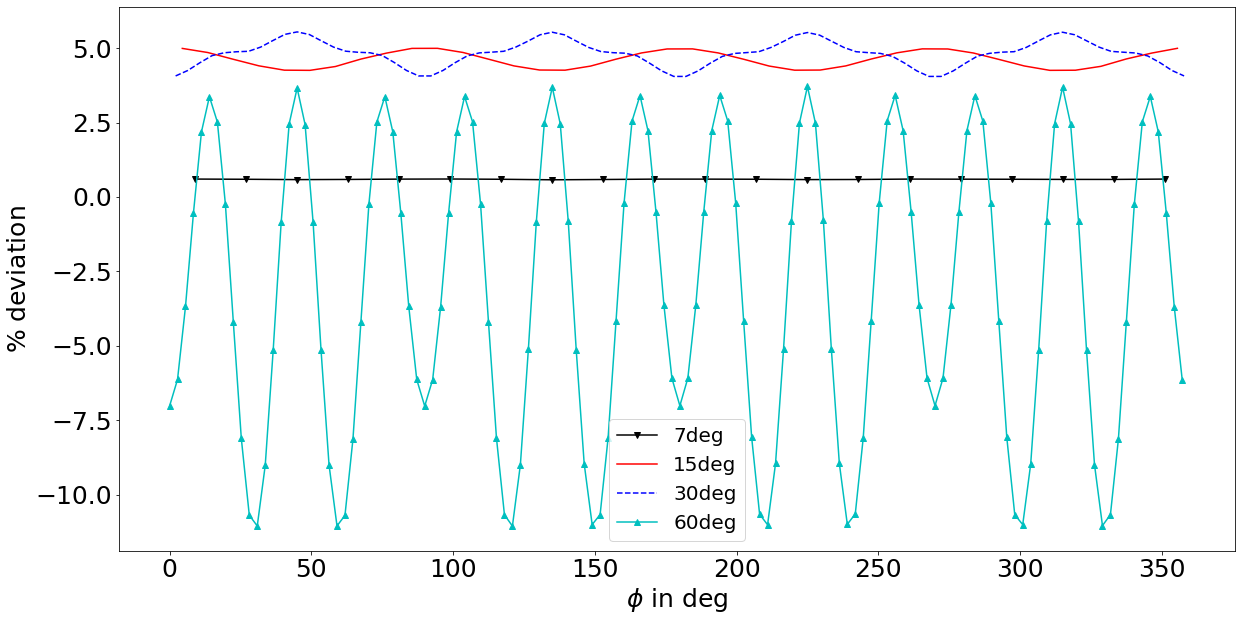

In [25]:
#print(np.rad2deg(theta[40]),np.rad2deg(theta[200]),np.rad2deg(theta[900]),np.rad2deg(theta[1800]))
#print(np.rad2deg(theta[3200]),np.rad2deg(theta[4600]))

fig, axes = plt.subplots(1,1,figsize=(10, 4))
#axes.plot(np.rad2deg(phi[theta == theta[20]]),reshp[theta == theta[20]],'y-o',label='4deg')
axes.plot(np.rad2deg(phi[theta == theta[40]]),reshp[theta == theta[40]],'k-v',label='7deg')
axes.plot(np.rad2deg(phi[theta == theta[200]]),reshp[theta == theta[200]],'r-',label='15deg')
axes.plot(np.rad2deg(phi[theta == theta[900]]),reshp[theta == theta[900]],'b--',label='30deg')
#axes.plot(np.rad2deg(phi[theta == theta[1800]]),reshp[theta == theta[1800]],'g-.',label='45deg')
axes.plot(np.rad2deg(phi[theta == theta[3200]]),reshp[theta == theta[3200]],'c-^',label='60deg')
#axes.plot(np.rad2deg(phi[theta == theta[4600]]),reshp[theta == theta[4600]],'m-v',label='75deg')
axes.tick_params(labelsize=25)
axes.set_ylabel('$\%$ deviation', fontsize=25)
axes.set_xlabel(r'$\phi$ in deg', fontsize=25)
axes.legend(fontsize=20)

fig.set_size_inches((20., 10.))
plt.savefig('fig_respbphi.pdf',bbox_inches='tight')